In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from sklearn import tree
#from sklearn import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import seaborn as sns
import plotting
import dataset_fctns
from scipy import stats
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

#from metpy.calc import relative_humidity_from_dewpoint
#from metpy.units import units
#relative_humidity_from_dewpoint(25 * units.degC, 12 * units.degC).to('percent')


In [2]:
def subsample(ds, subsample_frac = 0.5):
    np.random.seed(0)
    subsample = np.random.choice(ds.shape[0],np.int64(np.floor(ds.shape[0]*subsample_frac)), replace = False)
    #print(np.arange(ds.shape[0]),np.int64(np.floor(ds.shape[0]*subsample_frac)))
    ds_training = ds.loc[subsample, :]
    complement_of_subsample = np.delete(np.arange(ds.shape[0]), subsample)
    #print(len(complement_of_subsample), ds.shape[0], len(subsample))
    ds_verification = ds.loc[complement_of_subsample, :]
    return ds_training, ds_verification

def make_cumulative(ds, driver_variable = 'tas', numdays = 200, T_base = 0):
    ds[[f'{driver_variable} at day {n}' for n in range(numdays)]] = (np.maximum(ds[[f'{driver_variable} at day {n}' for n in range(numdays)]] - T_base, 0)).cumsum(axis = 1)
    return ds

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

def r2_modelled_observed(ds, phases):
    for phase in phases:
        print(f'\n{phase}')
        model_perts = ds[f'modelled time to {phase}'].dropna().values# - ds[f'modelled time to {phase}'].dropna().values.mean()
        obs_perts = ds[f'observed time to {phase}'].dropna().values# - ds[f'observed time to {phase}'].dropna().values.mean()
        RF_perts = ds[f'RF to {phase}'].dropna().values #- ds[f'RF to {phase}'].dropna().values.mean()
        r2_score_model = r2_score(obs_perts, model_perts)#.dropna()_score
        r2_score_RF = r2_score(obs_perts, RF_perts)#
        print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_model}', 
              f'\nML prediction emergence to {phase}, R2 score: {r2_score_RF}')
        
def box_plot_modelled_observed(ds, phases, font_size = 20):
    for phase in phases:
        fig, ax = plt.subplots(figsize = (10, 10))
        r2_score_model = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'modelled time to {phase}'].dropna().values)
        r2_score_RF = r2_score(ds[f'observed time to {phase}'].dropna().values, ds[f'RF to {phase}'].dropna().values)
        ax.boxplot([ds[f'modelled time to {phase}'].dropna(), 
                    ds[f'RF to {phase}'].dropna(), 
                    ds[f'observed time to {phase}'].dropna()], 
                   tick_labels=[f'modelled time emergence to\n{phase},\nR2 score: {r2_score_model}', 
                                f'ML prediction emergence to\n{phase},\nR2 score: {r2_score_RF}', 
                                f'observed time emergence to\n{phase}'], 
                   widths = 0.5, showfliers=False) #positions = [obs_this_phase['Stations_id'].unique()[0]],
        #ax.set_ylim(0, 100)
        plt.xticks(rotation = 90)
        ax.tick_params(labelsize = font_size)
        ax.set_title(f'Modelled and observed times to {phase}', fontsize = font_size)
        ax.set_ylabel('Time (days)', fontsize = font_size)
        fig.savefig(f'plots/ML_modelled_observed_{phase}.png', bbox_inches='tight')

In [3]:
def test_hyperparameters(ds_training, ds_verification, driver_variable = 'tas', numdays = 200, max_depth = 10, n_estimators = 100, min_samples_leaf = 1):
    X_train = ds_training[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_train = ds_training[[f'observed time to {phase}' for phase in phases]].values
    X_test = ds_verification[[f'{driver_variable} day {n}' for n in range(numdays)]].values
    y_test = ds_verification[[f'observed time to {phase}' for phase in phases]].values
    RF = RandomForestClassifier(max_depth = max_depth, n_estimators = n_estimators, min_samples_leaf = min_samples_leaf)
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    r2_score_RF = r2_score(y_test, y_pred)
    print(f'\nmodelled time emergence to {phase}, R2 score: {r2_score_RF}')

In [4]:
def get_station_locations(dataset, ds_stations):
    ds_stations.index = ds_stations['Stations_id']
    lat = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Breite' for count in range(len(dataset))])] #station_data.lookup(row_labels = dataset['Stations_id'], col_labels = ['geograph.Breite'])
    lon = [ds_stations._get_value(row, col) for row, col in zip(dataset['Stations_id'], ['geograph.Laenge' for count in range(len(dataset))])] #station_data._lookup(dataset['Stations_id'], ['geograph.Laenge'])
    dataset['lat'] = lat
    dataset['lon'] = lon
    dataset['lat'] = dataset['lat'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    dataset['lon'] = dataset['lon'].map(lambda x: x[0] if isinstance(x, float) == False else x)
    return dataset

In [5]:
ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')

In [6]:
def read_reanalysis():
    ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_t2m.csv')
    ds_t2m = ds_t2m.drop('Unnamed: 0', axis = 1)
    ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_d2m.csv')
    ds_d2m = ds_d2m.drop('Unnamed: 0', axis = 1)
    ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_ssrd.csv')
    ds_ssrd = ds_ssrd.drop('Unnamed: 0', axis = 1)
    ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data2_tp.csv')
    ds_tp = ds_tp.drop('Unnamed: 0', axis = 1)
    t_and_d = pd.merge(ds_t2m[[f't2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'observed time to beginning of emergence']],
                    ds_d2m[[f'd2m at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    rad_and_prec = pd.merge(ds_ssrd[[f'ssrd at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']],
                            ds_tp[[f'tp at day {day}' for day in range(200)] + ['Stations_id', 'Referenzjahr']], on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = pd.merge(t_and_d, rad_and_prec, on =['Stations_id', 'Referenzjahr'])
    ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
    ds_reanalysis['year'] = ds_reanalysis['year'].astype(int)
    return ds_reanalysis

In [7]:
def loc_and_SOS(ds_inputs, predictor_type = 'savgol'):
    station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')
    ds_inputs = dataset_fctns.get_station_locations(ds_inputs, station_data, check_lists = False)
    ds_inputs = dataset_fctns.add_SOS_to_df(ds_inputs)
    ds_inputs['WC SOS date'] = pd.to_datetime(ds_inputs['year'], format = '%Y') + pd.to_timedelta(ds_inputs['SOS'], unit = 'D')
    if predictor_type == 'savgol' or predictor_type == 'thresholds_dates' or predictor_type == 'percentiles_dates':
        if predictor_type == 'savgol':
            date_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile']
        elif predictor_type == 'thresholds_dates':
            date_columns = [f'first time crossing threshold {percent}%' for percent in range(100)] + [f'last time crossing threshold {percent}%' for percent in range(100)]
        elif predictor_type == 'percentiles_dates':
            date_columns = [f'first time crossing percentile {percent}%' for percent in range(100)] + [f'last time crossing percentile {percent}%' for percent in range(100)]
        for column in date_columns:
            ds_inputs[column] = pd.to_datetime(ds_inputs[column])
            ds_inputs[column] = ds_inputs[column] - ds_inputs['WC SOS date']
            ds_inputs[column] = ds_inputs[column].dt.days 
    return ds_inputs

In [9]:
ds_reanalysis = read_reanalysis()
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_savgol.csv')
ds_inputs = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds_inputs = ds_inputs.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs = loc_and_SOS(ds_inputs, predictor_type='savgol')
#ds_inputs = ds_inputs.rename(columns = {'first time crossing threshold 28%.1': 'first time crossing threshold 29%',
#                                        'first time crossing threshold 57%.1': 'first time crossing threshold 58%',
#                                        'last time crossing threshold 28%.1': 'last time crossing threshold 29%',
#                                        'last time crossing threshold 57%.1': 'last time crossing threshold 58%'})

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_25956\550226669.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [85]:
ds_reanalysis = read_reanalysis()
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_thresholds_dates.csv')
ds_inputs = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds_inputs = ds_inputs.rename(columns={'Stations_Id': 'Stations_id'})
ds_inputs = ds_inputs.rename(columns = {'first time crossing threshold 28%.1': 'first time crossing threshold 29%',
                                        'first time crossing threshold 57%.1': 'first time crossing threshold 58%',
                                        'last time crossing threshold 28%.1': 'last time crossing threshold 29%',
                                        'last time crossing threshold 57%.1': 'last time crossing threshold 58%'})
ds_inputs = loc_and_SOS(ds_inputs, predictor_type='thresholds_dates')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_6112\3277759550.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [97]:
ds_inputs

Unnamed: 0  year  Stations_id first time crossing threshold 0%  \
0             NaN  2004       7504.0                              NaN   
1             NaN  2005       7504.0                              NaN   
2             NaN  2007       7504.0                              NaN   
3             NaN  2008       7504.0                              NaN   
4             NaN  2009       7504.0                              NaN   
...           ...   ...          ...                              ...   
21872         NaN  2018      19914.0                              NaN   
21873         NaN  2019      19914.0                              NaN   
21874         NaN  2021      19914.0                              NaN   
21875         NaN  2022      19914.0                              NaN   
21876         NaN  2023      19914.0                              NaN   

      first time crossing threshold 1% first time crossing threshold 2%  \
0                                  NaN                              NaN   
1                                  NaN                              NaN   
2                                  NaN                              NaN   
3                                  NaN                              NaN   
4                                  NaN                              NaN   
...                                ...                              ...   
21872                              NaN                              NaN   
21873                              NaN                              NaN   
21874                              NaN                              NaN   
21875                              NaN                              NaN   
21876                              NaN                              NaN   

      first time crossing threshold 3% first time crossing threshold 4%  \
0                                  NaN                              NaN   
1                                  NaN                              NaN   
2                                  NaN                              NaN   
3                                  NaN                              NaN   
4                                  NaN                              NaN   
...                                ...                              ...   
21872                              NaN                              NaN   
21873                              NaN                              NaN   
21874                              NaN                              NaN   
21875                              NaN                              NaN   
21876                              NaN                              NaN   

      first time crossing threshold 5% first time crossing threshold 6%  ...  \
0                                  NaN                              NaN  ...   
1                                  NaN                              NaN  ...   
2                                  NaN                              NaN  ...   
3                                  NaN                              NaN  ...   
4                                  NaN                              NaN  ...   
...                                ...                              ...  ...   
21872                              NaN                              NaN  ...   
21873                              NaN                              NaN  ...   
21874                              NaN                              NaN  ...   
21875                              NaN                              NaN  ...   
21876                              NaN                              NaN  ...   

      tp at day 194 tp at day 195 tp at day 196 tp at day 197 tp at day 198  \
0          0.019881      0.006191      0.000877      0.000784      0.022205   
1          0.053771      0.006234      0.000042      0.000021      0.000007   
2          0.000512      0.000871      0.000591      0.052442      0.018322   
3          0.002487      0.015117      0.014200    

In [8]:
ds_reanalysis = read_reanalysis()
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times_MODIS_varied_percentiles3.csv')
ds_inputs = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds_inputs = ds_inputs.rename(columns={'Stations_Id': 'Stations_id'})
#ds_inputs = ds_inputs.rename(columns = {'first time crossing threshold 28%.1': 'first time crossing threshold 29%',
#                                        'first time crossing threshold 57%.1': 'first time crossing threshold 58%',
#                                        'last time crossing threshold 28%.1': 'last time crossing threshold 29%',
#                                        'last time crossing threshold 57%.1': 'last time crossing threshold 58%'})
ds_inputs = loc_and_SOS(ds_inputs, predictor_type='percentiles_dates')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_23496\550226669.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [9]:
def prepare_frame_for_ML(ds_inputs, phases, driver_variables, numdays = 200, predictor_type = 'savgol', cumulative = True, T_base = 6):
    phase_min_lengths = {'yellow ripeness': 50, 'beginning of flowering': 10, 'beginning of emergence': 0}
    ds_phase = ds_inputs.copy() #pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
    if predictor_type == 'savgol':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['mingrad', 't2m at day 0'], how='any')#, 'emergence date' 'NDVI interpolated at 2021-04-07'
    elif predictor_type == 'savgol_raw':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['mingrad', 't2m at day 0'], how='any')#'NDVI interpolated at 2021-04-07'
    elif predictor_type == 'thresholds':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['first time crossing threshold 0%', 't2m at day 0'], how='any')
    elif predictor_type == 'percentiles':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['first time crossing percentile 0%', 't2m at day 0'], how='any')
    elif predictor_type == 'linterp':
        ds_phase = ds_phase.dropna(subset=[f'observed time to {phase}' for phase in phases] + ['linterp day 0', 't2m at day 0'], how='any')
    #ds_ripeness = ds_ripeness.reset_index()#.drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
    if cumulative:
        ds_phase = make_cumulative(ds_phase, driver_variable = 't2m', numdays = 200, T_base = T_base)
    day_columns = [f'observed time to {phase}' for phase in phases]
    for column in day_columns:
        ds_phase[column] = pd.to_timedelta(ds_phase[column]).dt.days
    for phase in phases:
        ds_phase = ds_phase.where(ds_phase[f'observed time to {phase}'] > phase_min_lengths[phase]).dropna(how = 'all')
    return ds_phase

In [13]:
ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'savgol', T_base = 6)#, cumulative=False)
ds_flowering = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'savgol')#, cumulative=False)
ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'savgol')#, cumulative=False)

KeyError: ['mingrad']

In [10]:
ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'percentiles', T_base = 6)#, cumulative=False)
ds_flowering = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'percentiles')#, cumulative=False)
ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'percentiles')#, cumulative=False)

In [87]:
ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m'], numdays = 200, predictor_type = 'thresholds', T_base = 6)#, cumulative=False)
ds_flowering = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m'], numdays = 200, predictor_type = 'thresholds')#, cumulative=False)
ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m'], numdays = 200, predictor_type = 'thresholds')#, cumulative=False)

In [22]:
def plot_LSP_observed(ds, phases = ['yellow ripeness'], predictor_type = 'percentiles'):
    fig, axes = plt.subplots(1, 6, figsize = (20, 5))
    fig.tight_layout()
    if predictor_type == 'percentiles':
        predictors = ['first time crossing percentile 15%', 'first time crossing percentile 50%', 'first time crossing percentile 90%', 
                    'last time crossing percentile 15%', 'last time crossing percentile 50%', 'last time crossing percentile 90%']
    else:
        predictors = ['minday', 'maxday', 'mingrad', 'maxgrad', 'second last 75 percentile', 'last 75 percentile']
    #predictors = ['first time crossing threshold 15%', 'first time crossing threshold 50%', 'first time crossing threshold 90%', 
    #                'last time crossing threshold 15%', 'last time crossing threshold 50%', 'last time crossing threshold 90%']
    observed_variables = [f'observed time to {phase}' for phase in phases]
    for predictor_index, predictor in enumerate(predictors):
        if predictor == 'second last 75 percentile' or predictor == 'last 75 percentile':
            ds_no_outliers = ds.where(ds[predictor] > 0).dropna(how='all')
        elif predictor == 'mingrad' or predictor == 'maxgrad':
            ds_no_outliers = ds#.where(ds['mingrad'] > ds['maxgrad']).dropna(how='all')
            if predictor == 'mingrad':
                ds_no_outliers = ds_no_outliers#.where((ds_no_outliers[predictor] > 50)).dropna(how='all')
            elif predictor == 'maxgrad':
                ds_no_outliers = ds_no_outliers#.where(ds_no_outliers[predictor] < 150).dropna(how='all')
        elif predictor == 'maxday':
            ds_no_outliers = ds#.where((ds[predictor] < 150)*(ds[predictor] > 50)).dropna(how='all')
        else:
            if predictor_type == 'percentiles':
                ds_no_outliers = ds.where(ds[predictor] > 0).dropna(how='all')
        for observed_variable_index, observed_variable in enumerate(observed_variables):
            minval = min(ds_no_outliers[predictor].min(), ds_no_outliers[observed_variable].min()) - 1
            maxval = max(ds_no_outliers[predictor].max(), ds_no_outliers[observed_variable].max()) + 1
            axs = axes[predictor_index]#, observed_variable_index
            sns.regplot(x=predictor, y=observed_variable, data=ds_no_outliers, ax=axs,
                        scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
            axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)

In [42]:
ds_emergence['observed time to beginning of emergence'].max()

61.0

In [83]:
ds_emergence['last time crossing threshold 15%']

18       2017-10-13
19       2018-11-12
20       2019-11-09
21       2020-11-05
22       2021-11-01
            ...    
21618    2018-11-13
21619    2019-10-08
21620    2020-11-01
21621    2021-11-01
21622    2022-11-12
Name: last time crossing threshold 15%, Length: 2551, dtype: object

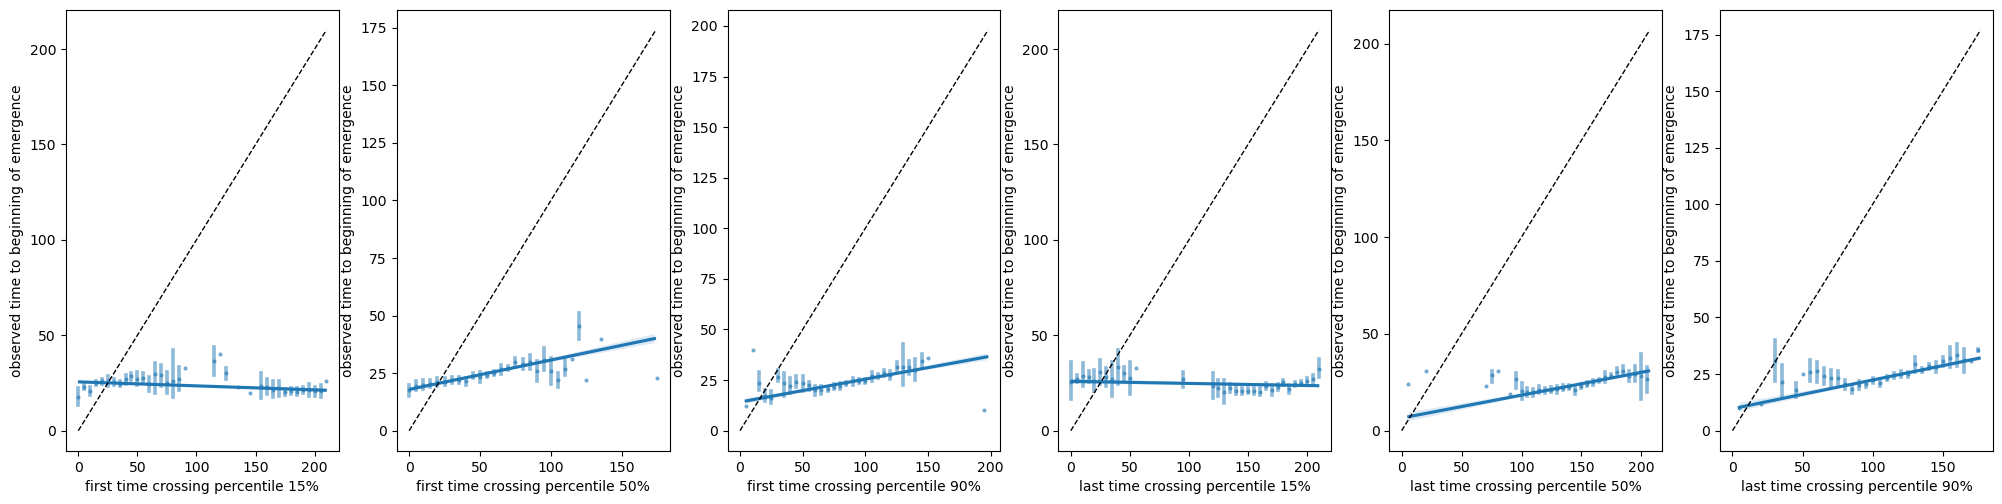

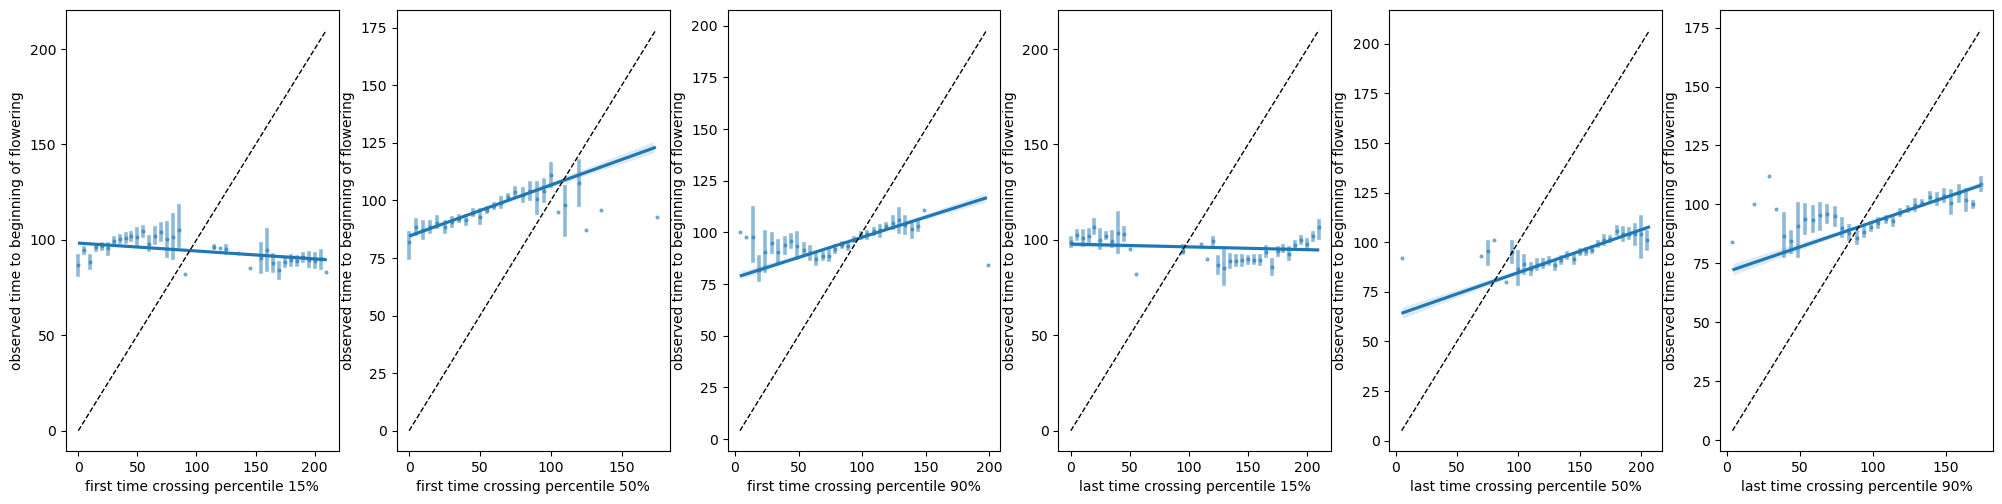

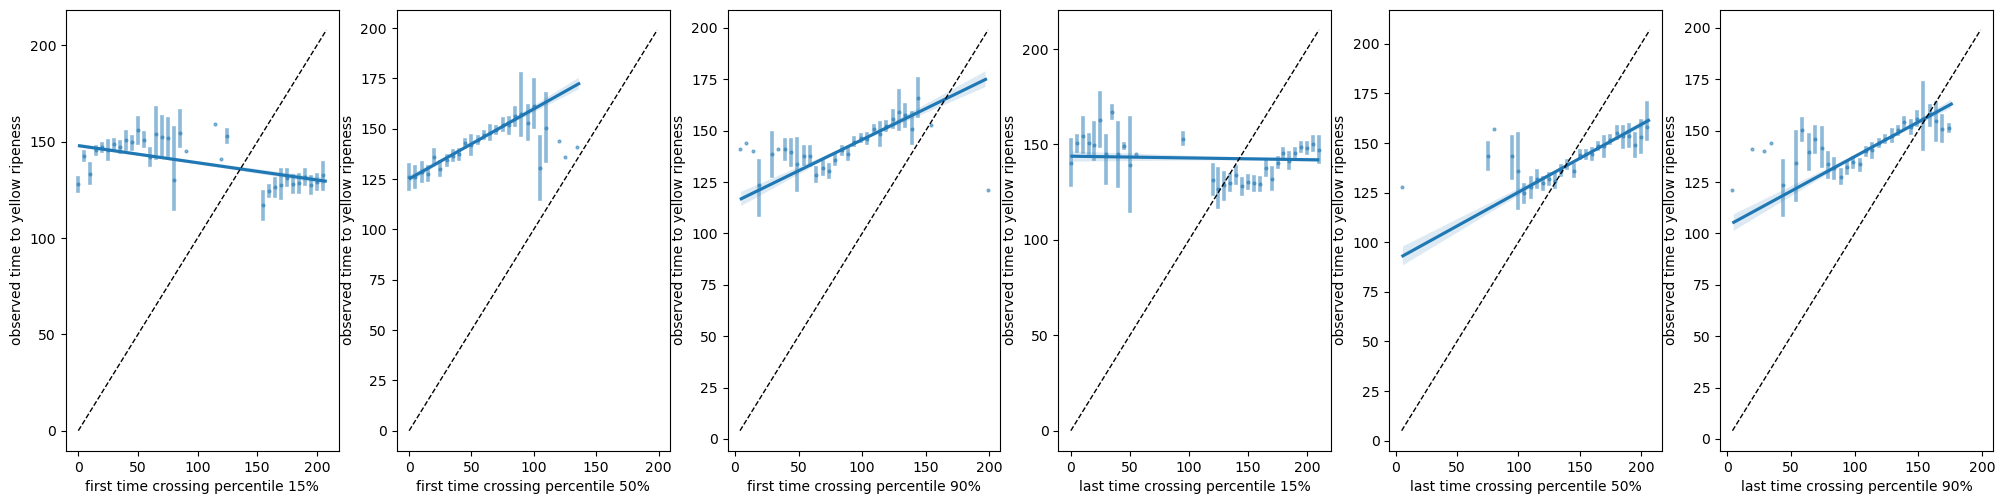

In [23]:
plot_LSP_observed(ds_emergence, phases = ['beginning of emergence'])
plot_LSP_observed(ds_flowering, phases = ['beginning of flowering'])
plot_LSP_observed(ds_ripeness, phases = ['yellow ripeness'])

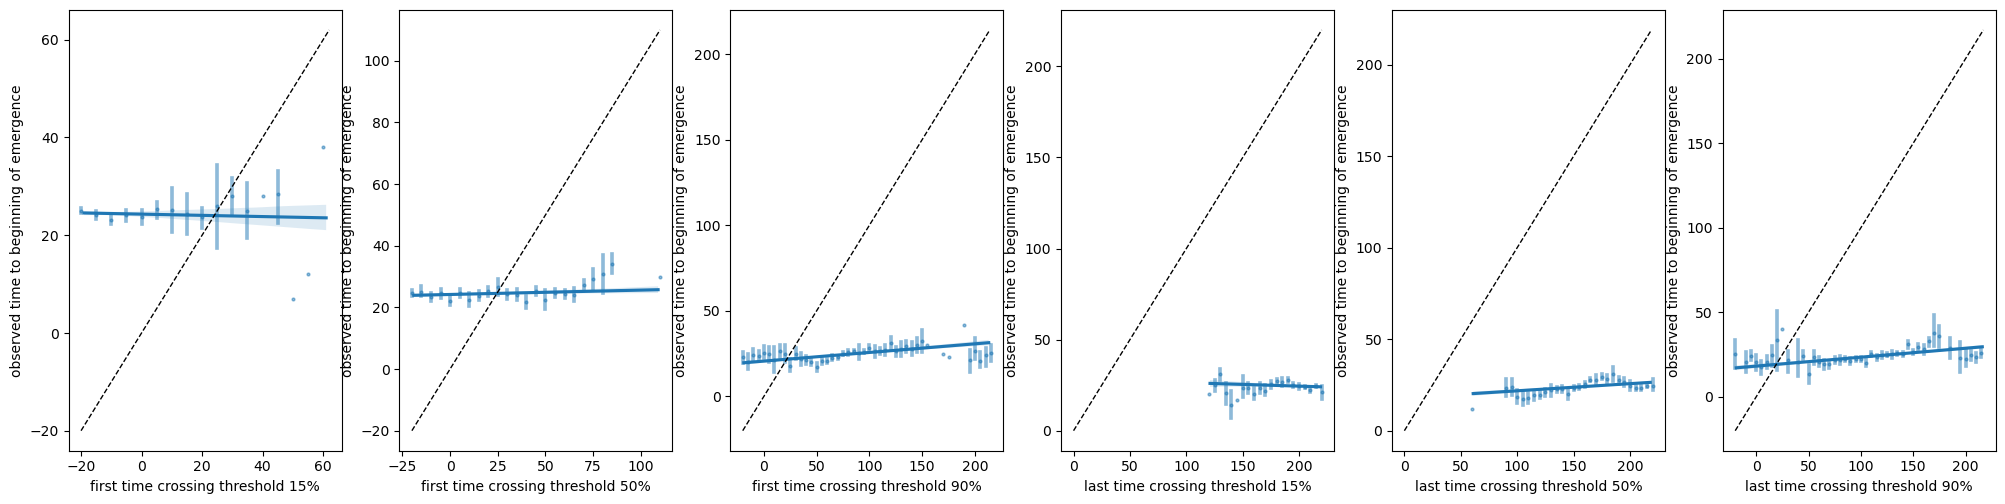

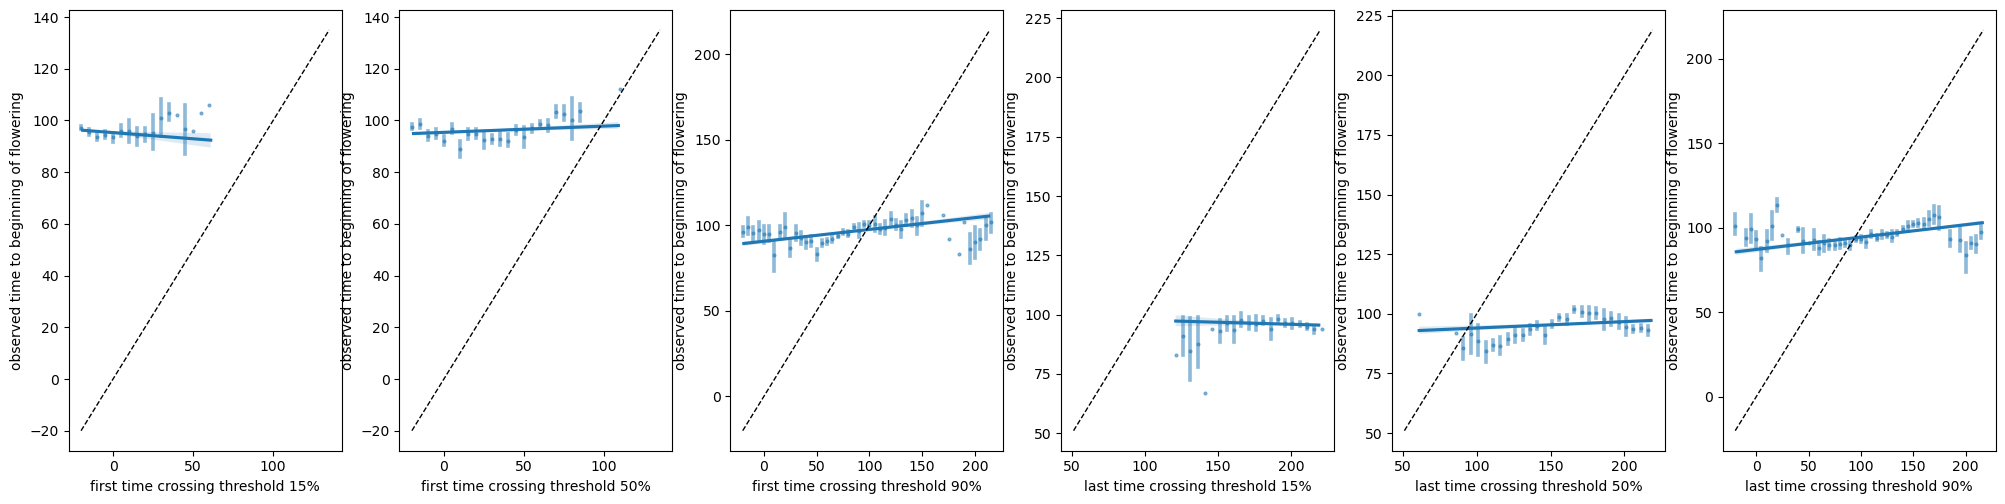

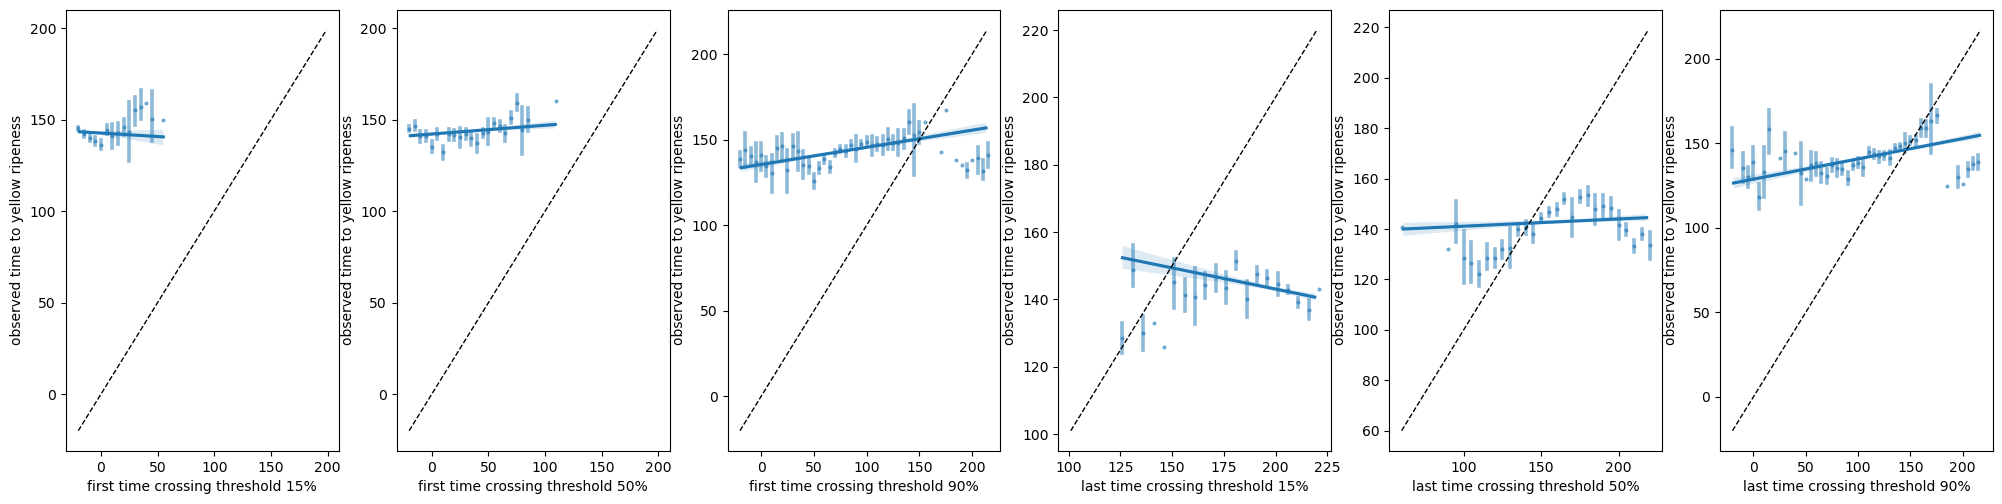

In [89]:
plot_LSP_observed(ds_emergence, phases = ['beginning of emergence'])
plot_LSP_observed(ds_flowering, phases = ['beginning of flowering'])
plot_LSP_observed(ds_ripeness, phases = ['yellow ripeness'])

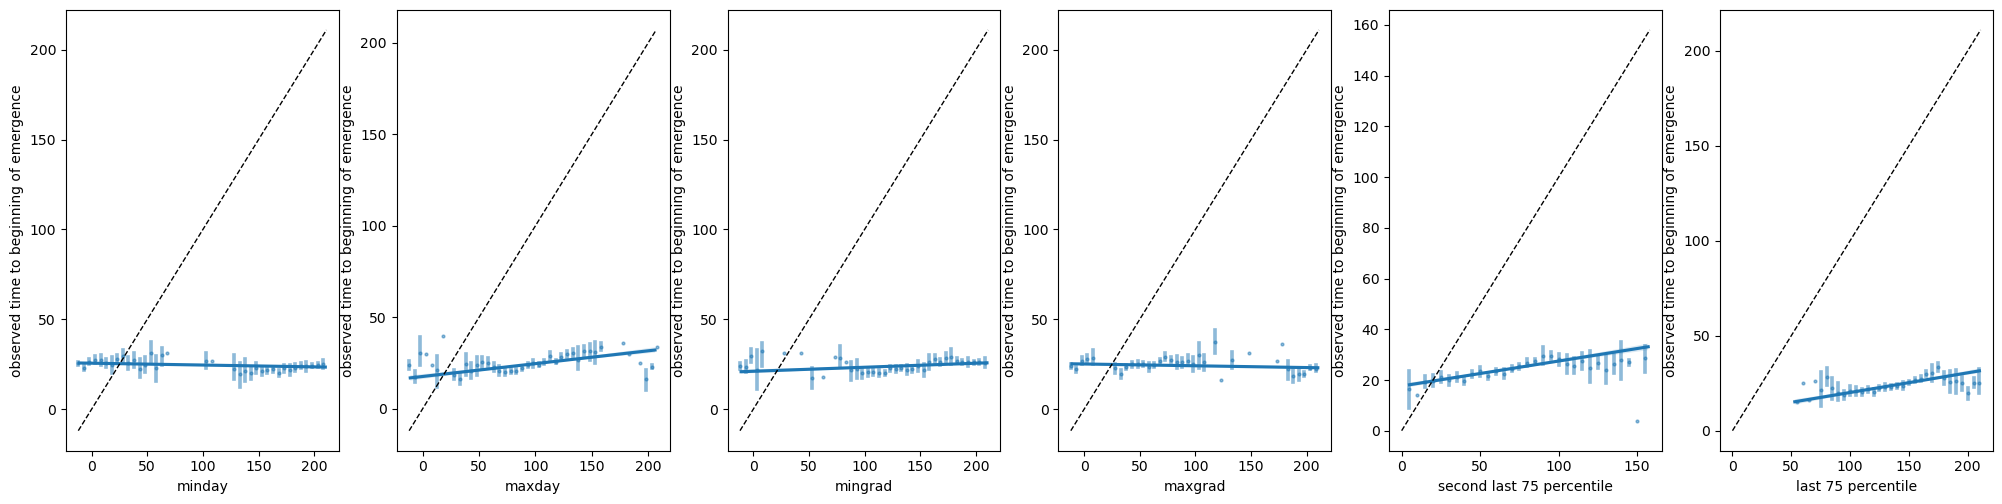

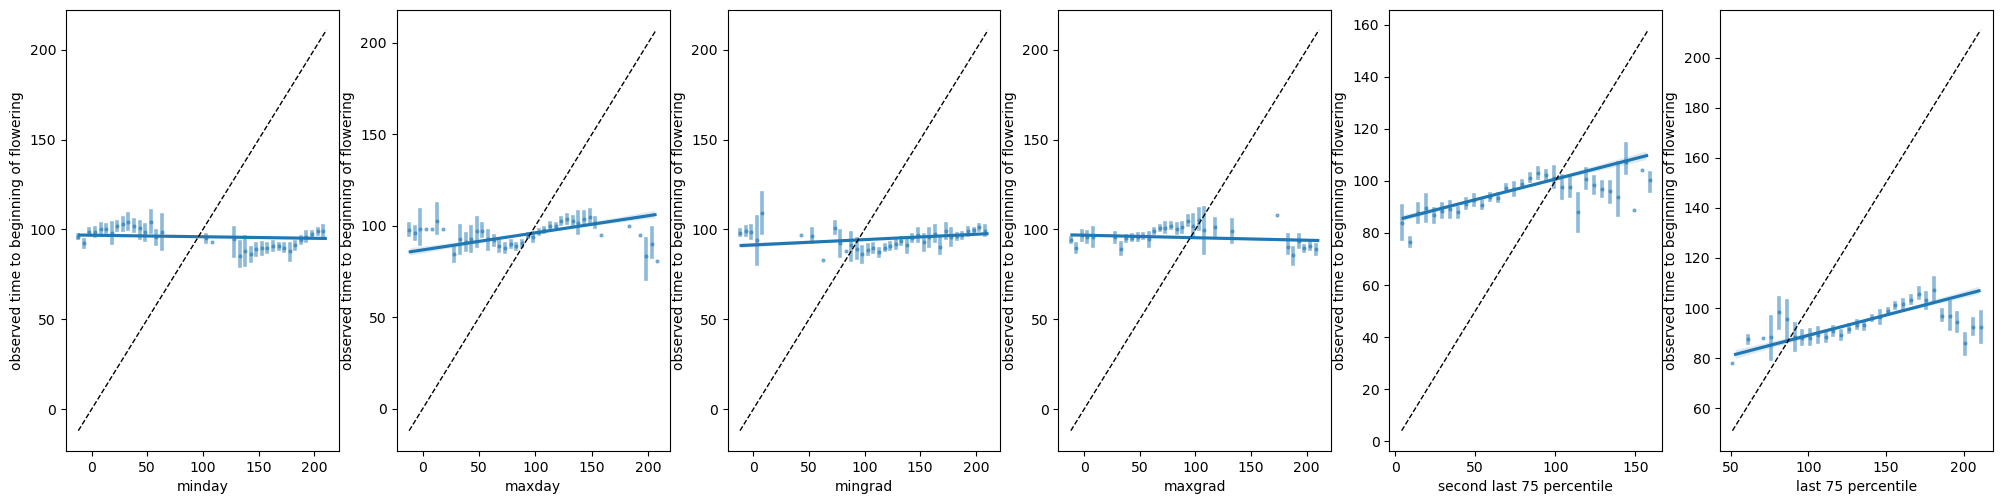

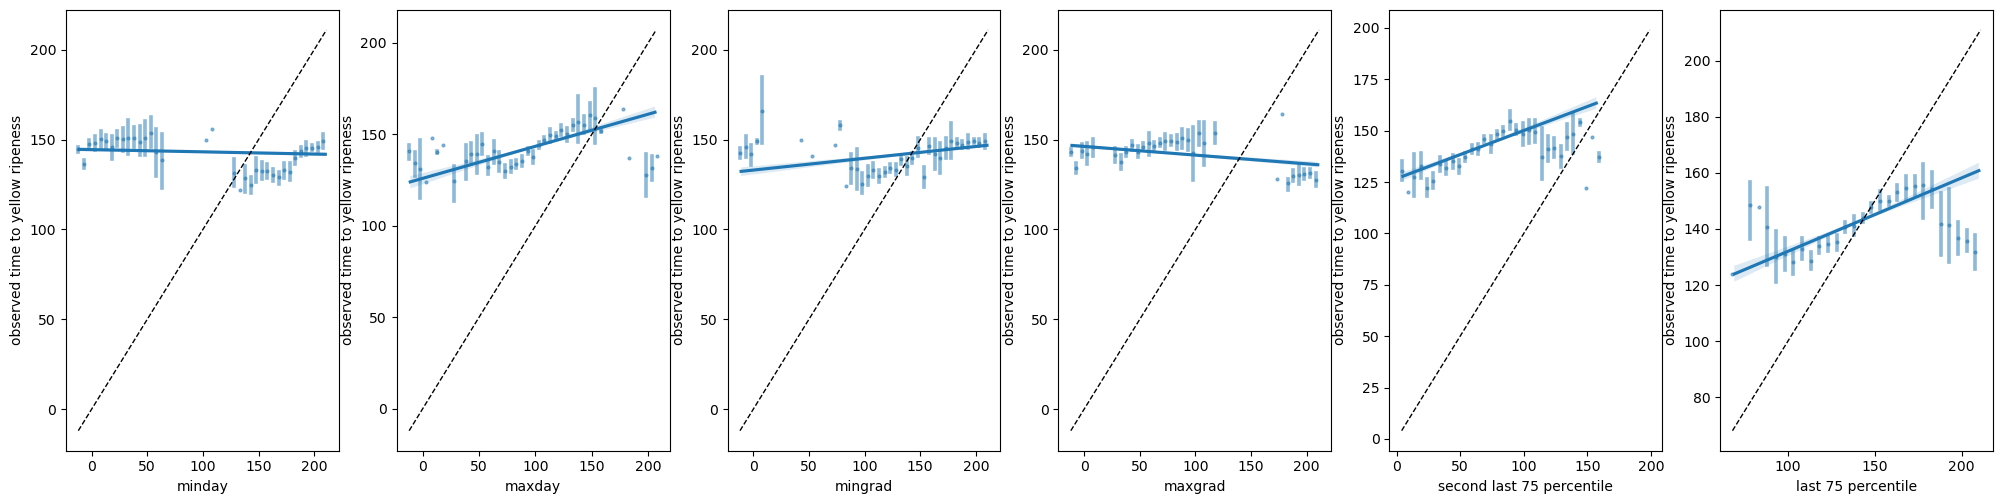

In [51]:
plot_LSP_observed(ds_emergence, phases = ['beginning of emergence'])
plot_LSP_observed(ds_flowering, phases = ['beginning of flowering'])
plot_LSP_observed(ds_ripeness, phases = ['yellow ripeness'])

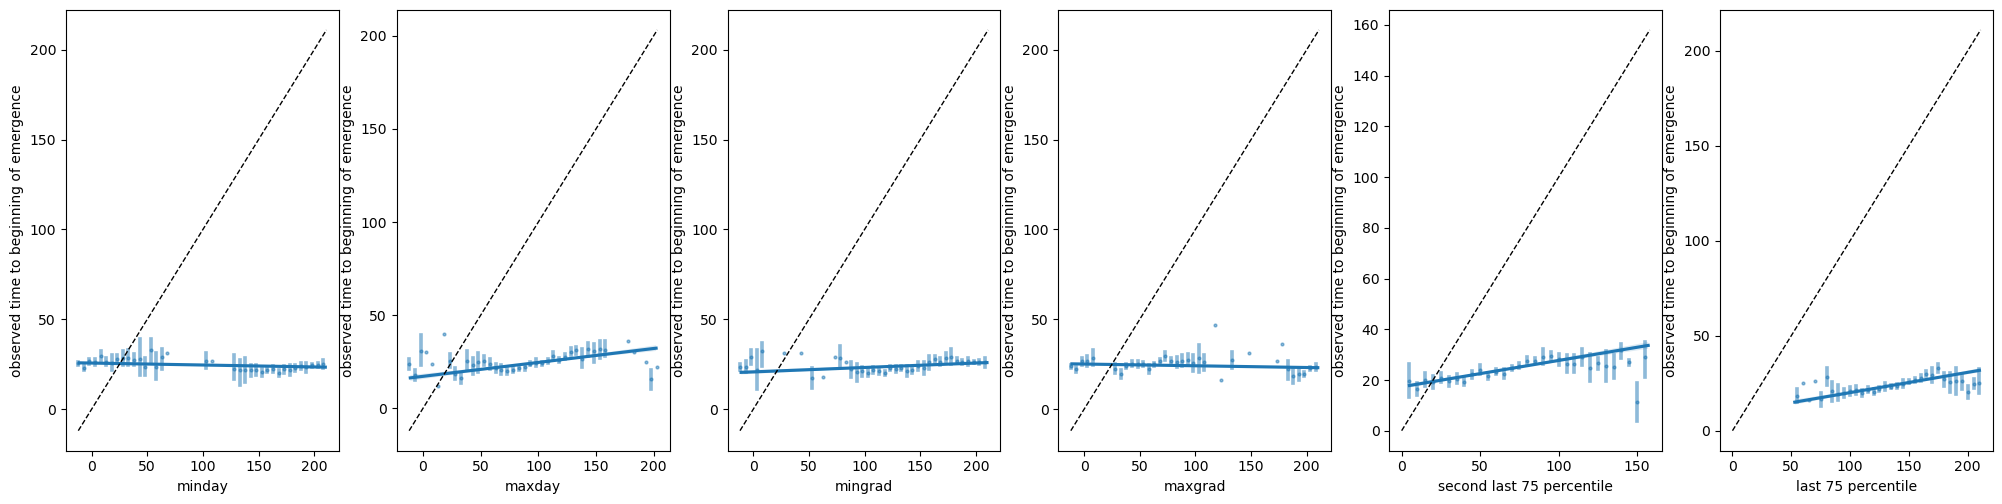

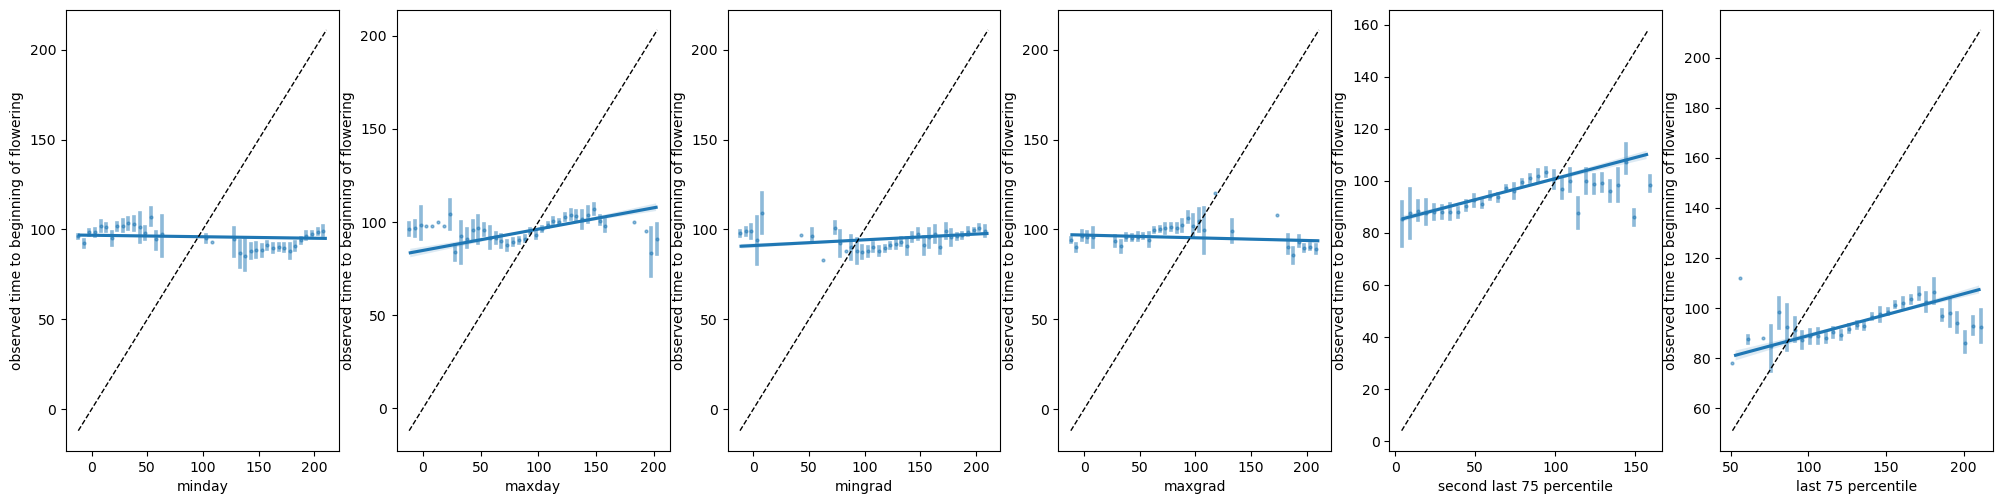

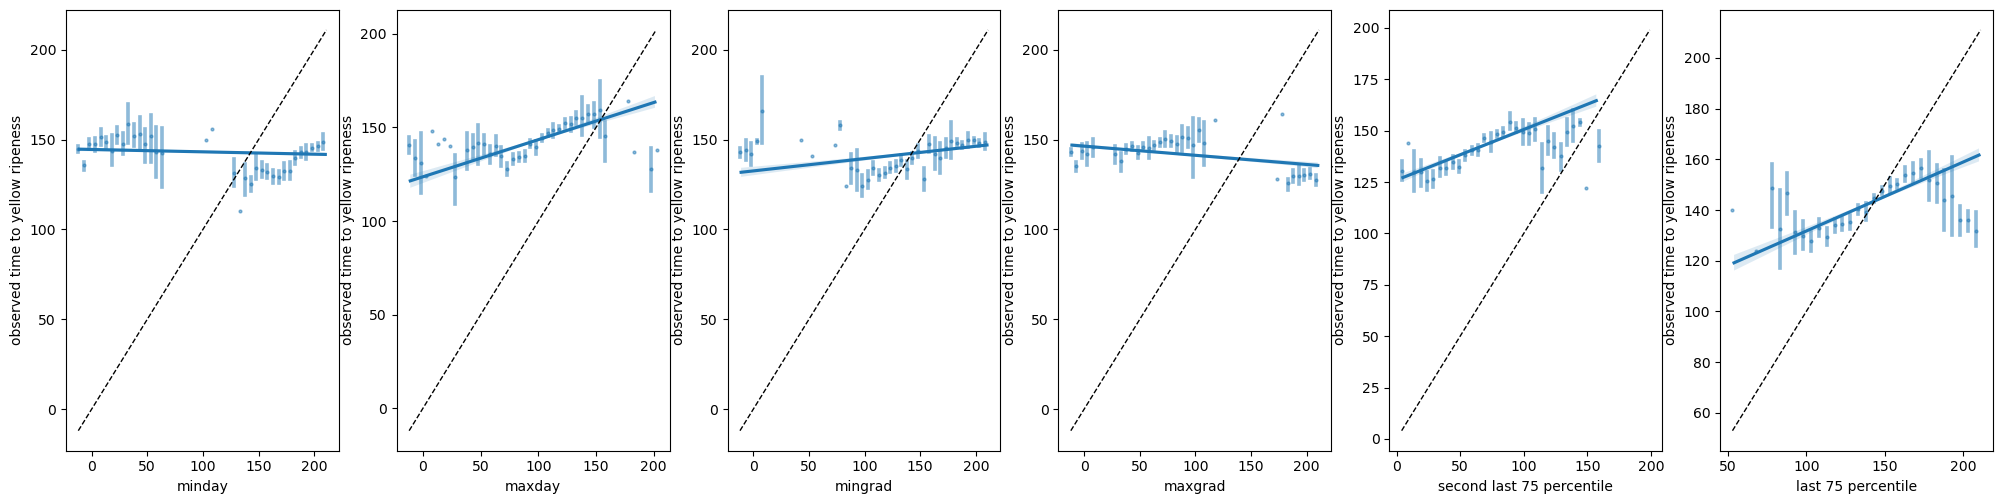

In [94]:
plot_LSP_observed(ds_emergence, phases = ['beginning of emergence'])
plot_LSP_observed(ds_flowering, phases = ['beginning of flowering'])
plot_LSP_observed(ds_ripeness, phases = ['yellow ripeness'])

In [163]:
def combine_columns(ds):
    list_of_arrays = []
    for day_index in range(200):
        day_array = ds[['year', 'Stations_id', 'lat', 'lon', 'SOS', 'WC SOS date', f'linterp day {day_index}', f't2m at day {day_index}']].set_index(['Stations_id', 'year']).to_xarray()
        day_array = day_array.rename({f'linterp day {day_index}': 'linterp', f't2m at day {day_index}': 't2m'})
        day_array = day_array.expand_dims('time')
        day_array = day_array.assign_coords(time=("time", [day_index]))
        list_of_arrays.append(day_array)
    return xr.concat(list_of_arrays, dim='time')
#ripeness_array#.expand_dims(dim={'time':200})
#ripeness

In [290]:
def MVI_array(da, index_variable = 'time', response_variable = 'linterp', bins = np.arange(0, 201, 10), original_length = 1):
    binned = da.groupby_bins(index_variable, bins, labels = bins[:-1])
    maxs = binned.max()
    max_locs = binned.map(lambda arr: np.argmax(arr))
    max_locs[index_variable] = max_locs[f'{index_variable}_bins'] + max_locs[response_variable]*original_length
    maxs['MVI NDVI'] = ((f'{index_variable}_bins'), np.interp(maxs[f'{index_variable}_bins'], max_locs[index_variable], maxs[response_variable]))
    return maxs

In [298]:
def to_temp_coords(da, new_coords = np.arange(0, 1701, 10)):
    da['time_index'] = da['time']#
    temps_maxed = da.groupby('t2m').max().set_coords('time_index')
    temps_interpolated = temps_maxed.interp(t2m=new_coords, kwargs={"fill_value": 0})
    return temps_interpolated

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim

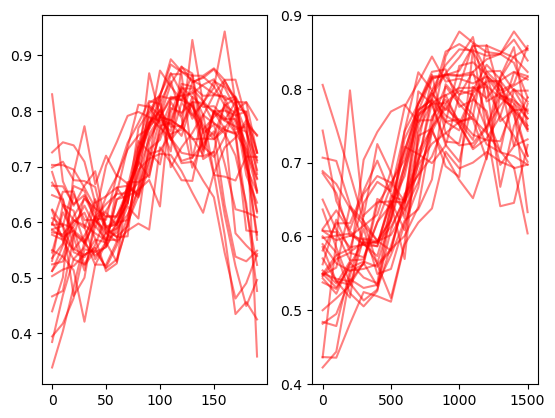

In [299]:
fig, axs = plt.subplots(1, 2)
for statid in ripeness_array['Stations_id'].values[:10]:
    for year in ripeness_array['year'].values:
        ripeness_array_at_year = ripeness_array.sel(Stations_id = statid, year = year)
        if np.isnan(ripeness_array_at_year['t2m'].isel(time = 0)):
            continue
        time_binned = ripeness_array_at_year.groupby_bins('time', np.arange(0, 201, 10), labels = np.arange(0, 191, 10))
        maxs = MVI_array(ripeness_array_at_year, index_variable = 'time', response_variable = 'linterp', bins = np.arange(0, 201, 10), original_length = 1)
        axs[0].plot(maxs['time_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        temps_interpolated = to_temp_coords(ripeness_array_at_year, new_coords = np.arange(0, 1601, 10))
        maxs = MVI_array(temps_interpolated, index_variable = 't2m', response_variable = 'linterp', bins = np.arange(0, 1601, 100), original_length = 10)
        axs[1].plot(maxs['t2m_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)

In [164]:
ripeness_array = combine_columns(ds_ripeness)

In [227]:
for_resamples.reset_index('t2m').reset_coords('t2m').rename_dims({'t2m':'time'}).set_index({'time':'time_index'})

<xarray.Dataset> Size: 10kB
Dimensions:      (time: 191)
Coordinates:
    Stations_id  float64 8B 7.623e+03
    year         float64 8B 2.017e+03
  * time         (time) int32 764B 0 6 7 9 13 14 15 ... 194 195 196 197 198 199
Data variables:
    lat          (time) float64 2kB 54.67 54.67 54.67 ... 54.67 54.67 54.67
    lon          (time) float64 2kB 9.133 9.133 9.133 ... 9.133 9.133 9.133
    SOS          (time) float64 2kB 103.0 103.0 103.0 ... 103.0 103.0 103.0
    WC SOS date  (time) datetime64[ns] 2kB 2017-04-14 2017-04-14 ... 2017-04-14
    linterp      (time) float64 2kB 0.1569 0.6821 0.6925 ... 0.5416 0.5349
    t2m          (time) float64 2kB 1.58 2.473 5.258 ... 1.567e+03 1.568e+03

In [198]:
np.unique(ripeness_array_at_year['t2m'].values).shape
max_at_temp = ripeness_array_at_year.groupby('t2m').max()
time_at_temp = ripeness_array_at_year.groupby('t2m')['time'].max()
time_at_temp2 = ripeness_array_at_year.groupby('t2m')['time'].min()
#ripeness_array_at_year['maxed_linterp'] = ripeness_array_at_year['t2m'].map(max_at_temp)

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


KeyError: 'time'

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\xarray\core\concat.py:540: UserWarning: No index created for dimension t2m because variable t2m is not a coordinate. To create an index for t2m, please first call `.set_coords('t2m')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim

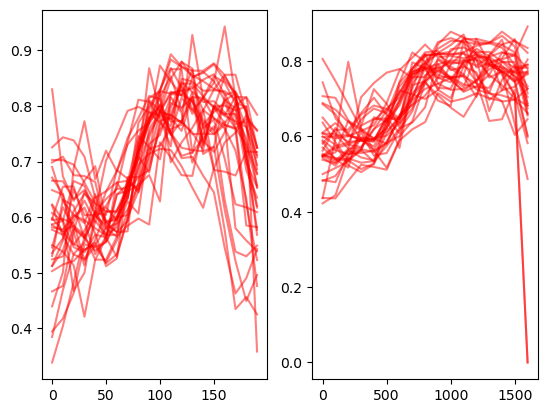

In [283]:
fig, axs = plt.subplots(1, 2)
for statid in ripeness_array['Stations_id'].values[:10]:
    for year in ripeness_array['year'].values:
        ripeness_array_at_year = ripeness_array.sel(Stations_id = statid, year = year)
        if np.isnan(ripeness_array_at_year['t2m'].isel(time = 0)):
            continue
        time_binned = ripeness_array_at_year.groupby_bins('time', np.arange(0, 201, 10), labels = np.arange(0, 191, 10))
        maxs = time_binned.max()
        max_locs = time_binned.map(lambda arr: np.argmax(arr))
        max_locs['time'] = max_locs['time_bins'] + max_locs['linterp']
        maxs['MVI NDVI'] = (('time_bins'), np.interp(maxs['time_bins'], max_locs['time'], maxs['linterp']))
        axs[0].plot(maxs['time_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        #axs[0].plot(ripeness_array_at_year['time'], ripeness_array_at_year['linterp'], color = 'red', alpha = 0.5)
        ripeness_array_at_year['time_index'] = ripeness_array_at_year['time']#
        temps_maxed = ripeness_array_at_year.groupby('t2m').max().set_coords('time_index')
        temps_interpolated = temps_maxed.interp(t2m=np.arange(0, 1701, 10), kwargs={"fill_value": 0})#"extrapolate"})
        #ax.plot(temps_interpolated['t2m'], temps_interpolated['linterp'], color = 'red', alpha = 0.5)
        temp_binned = temps_interpolated.groupby_bins('t2m', np.arange(0, 1701, 100), labels = np.arange(0, 1601, 100))
        maxs = temp_binned.max()
        max_locs = temp_binned.map(lambda arr: np.argmax(arr))
        max_locs['t2m'] = max_locs['t2m_bins'] + 10*max_locs['linterp']
        maxs['MVI NDVI'] = (('t2m_bins'), np.interp(maxs['t2m_bins'], max_locs['t2m'], maxs['linterp']))
        axs[1].plot(maxs['t2m_bins'], maxs['MVI NDVI'], color = 'red', alpha = 0.5)
        #print(np.unique(ripeness_array_at_year['t2m'].values).shape, statid, year)

In [62]:
ds_ripeness = prepare_frame_for_ML(ds_inputs, ['yellow ripeness'], ['t2m', 'd2m', 'ssrd', 'tp'], numdays = 200, predictor_type = 'thresholds')
ds_flowering = prepare_frame_for_ML(ds_inputs, ['beginning of flowering'], ['t2m', 'd2m', 'ssrd', 'tp'], numdays = 200, predictor_type = 'thresholds')
ds_emergence = prepare_frame_for_ML(ds_inputs, ['beginning of emergence'], ['t2m', 'd2m', 'ssrd', 'tp'], numdays = 200, predictor_type = 'thresholds')
#ds_flowering = ds_flowering.where(ds_flowering['second last 75 percentile'] > 0).dropna()
#ds_ripeness = ds_ripeness.where(ds_ripeness['second last 75 percentile'] > 0).dropna()

In [63]:
def correlations_for_phase(ds, phases = ['beginning of flowering']):
    corrs = ds[[f'observed time to {phase}' for phase in phases] + [f'first time crossing threshold {int(percentage)}%' for percentage in np.arange(0, 100)] + [f'last time crossing threshold {int(percentage)}%' for percentage in np.arange(0, 100)]].corr()[[f'observed time to {phase}' for phase in phases]+ ['first time crossing threshold 99%']]
    corrs = corrs.drop([f'observed time to {phase}' for phase in phases])
    return corrs

In [15]:
def correlations_for_phase(ds, phases = ['beginning of flowering']):
    for percentage in range(100):
        ds = ds.where(ds[f'first time crossing percentile {int(percentage)}%']>0).dropna(how = 'any')
    corrs = ds[[f'observed time to {phase}' for phase in phases] + [f'first time crossing percentile {int(percentage)}%' for percentage in np.arange(0, 100)] + [f'last time crossing percentile {int(percentage)}%' for percentage in np.arange(0, 100)]].corr()[[f'observed time to {phase}' for phase in phases]+ ['first time crossing percentile 99%']]
    corrs = corrs.drop([f'observed time to {phase}' for phase in phases])
    return corrs

In [16]:
ds_flowering_reduced = ds_flowering.sample(frac=0.5)#.where(ds_flowering['first time crossing threshold 50%'] > 16).sample(frac=0.5)
ds_emergence_reduced = ds_emergence.sample(frac=0.5)#.where(ds_emergence['first time crossing threshold 50%'] > 16).sample(frac=0.5)
ds_ripeness_reduced = ds_ripeness.sample(frac=0.5)#.where(ds_ripeness['first time crossing threshold 50%'] > 16).sample(frac=0.5)

In [17]:
corrs_flowering = correlations_for_phase(ds_flowering_reduced, phases=['beginning of flowering'])
corrs_emergence = correlations_for_phase(ds_emergence_reduced, phases=['beginning of emergence'])
corrs_ripeness = correlations_for_phase(ds_ripeness_reduced, phases=['yellow ripeness'])

In [18]:
def plot_corrs(corr_ds, phase):
    fig, axs = plt.subplots()
    axs.plot(np.arange(0, 100), corr_ds[f'observed time to {phase}'][:100], label = 'first time at this threshold')
    axs.plot(np.arange(0, 100), corr_ds[f'observed time to {phase}'][100:], label = 'last time at this threshold')
    fig.legend()

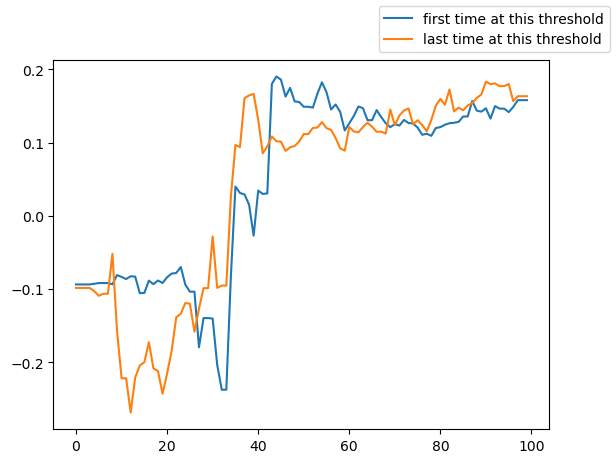

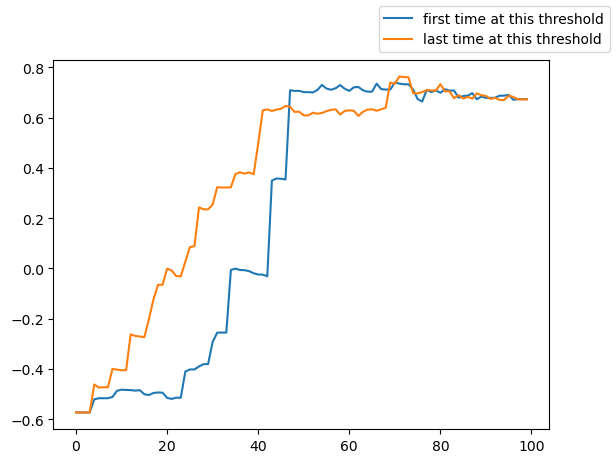

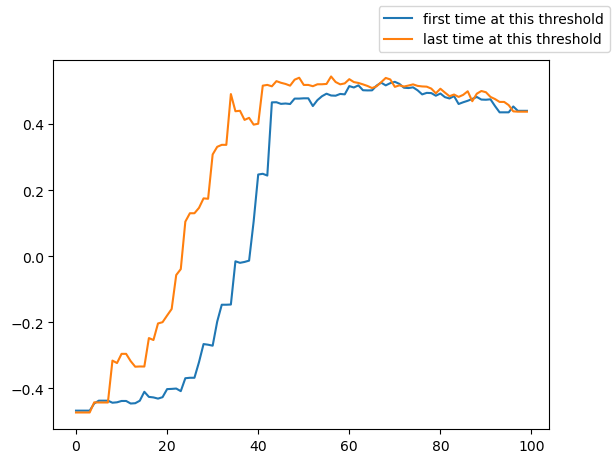

In [19]:
plot_corrs(corrs_emergence, 'beginning of emergence')
plot_corrs(corrs_flowering, 'beginning of flowering')
plot_corrs(corrs_ripeness, 'yellow ripeness')

In [27]:
#ds_ripeness.columns.tolist()

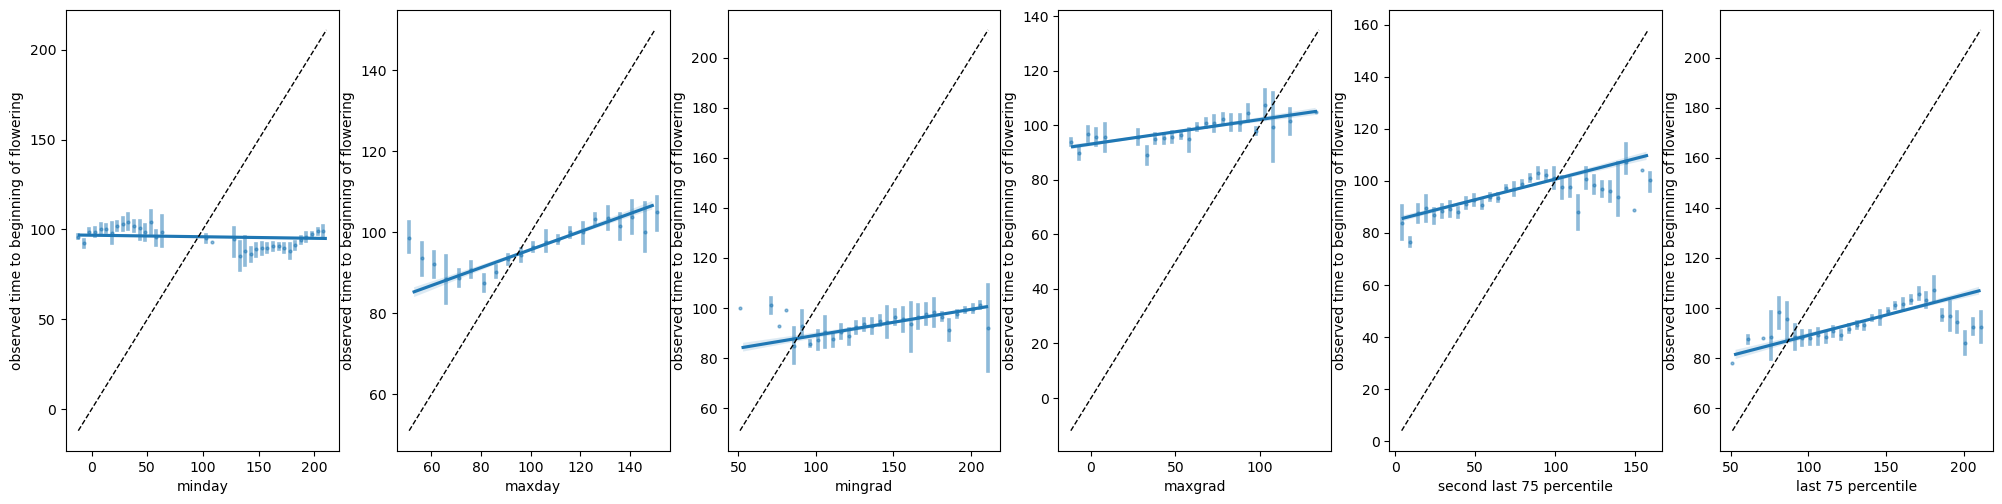

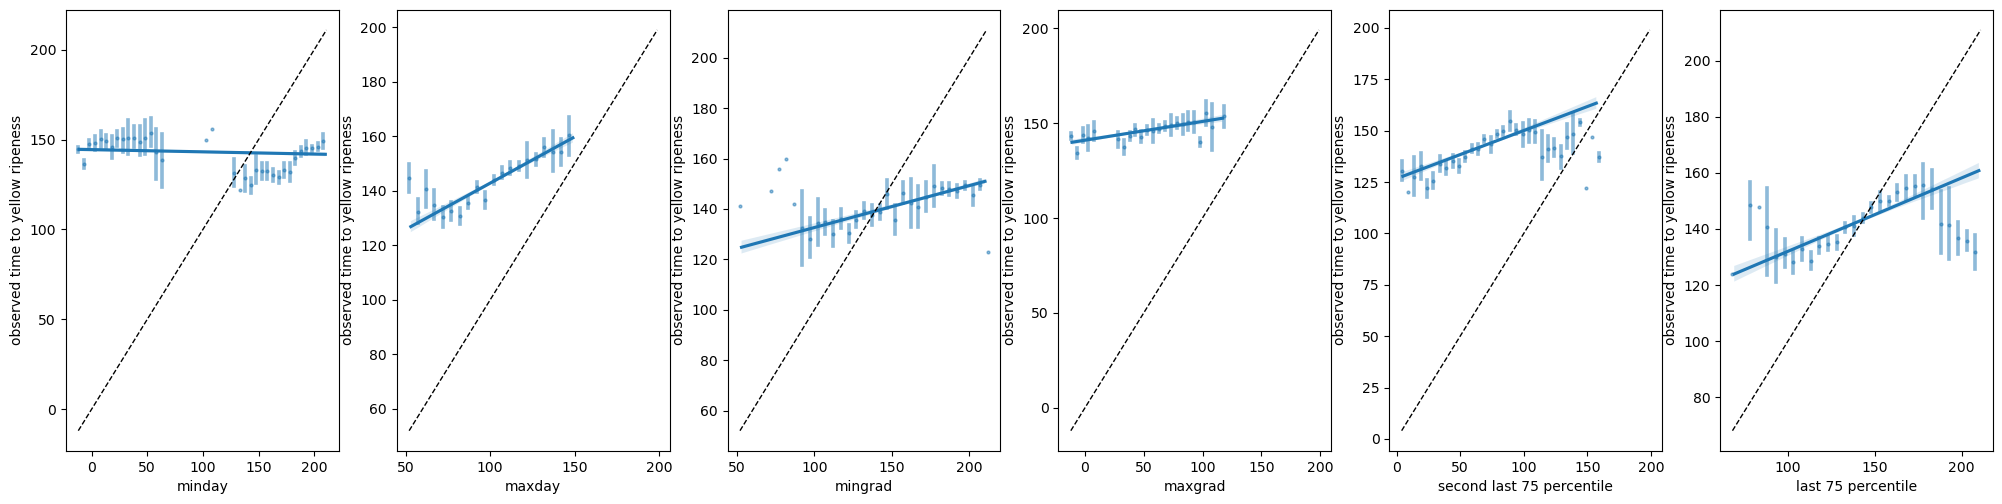

In [30]:
ds_flowering_reduced = ds_flowering.where(ds_flowering['second last 75 percentile'] > 120).dropna()# + ds_flowering['SOS'] 
ds_ripeness_reduced = ds_ripeness.where(ds_ripeness['second last 75 percentile'] > 120).dropna()#+ ds_ripeness['SOS'] 

In [60]:
ds_ripeness_reduced

Unnamed: 0    year  Stations_id  mingrad  maxgrad  minday  maxday  \
7           701.0  2007.0       7504.0     73.0    106.0    91.0    66.0   
8           661.0  2008.0       7504.0    166.0    209.0   180.0    40.0   
9           621.0  2009.0       7504.0    130.0     12.0   146.0    34.0   
10          581.0  2010.0       7504.0    127.0    163.0   146.0    93.0   
11          541.0  2011.0       7504.0    227.0      6.0     6.0   119.0   
...           ...     ...          ...      ...      ...     ...     ...   
32807       463.0  2013.0      19700.0    137.0     22.0   165.0    93.0   
32808       423.0  2014.0      19700.0    100.0      6.0   119.0    93.0   
32814       183.0  2020.0      19700.0    113.0    230.0   150.0    87.0   
32817        63.0  2023.0      19700.0    179.0    125.0   230.0   160.0   
32881        62.0  2023.0      19722.0    185.0      9.0     9.0   166.0   

       second last 75 percentile  last 75 percentile  t2m at day 0  ...  \
7                          110.0               136.0     13.823691  ...   
8                          137.0               157.0      6.079668  ...   
9                           66.0                82.0     10.964367  ...   
10                         182.0               190.0      6.883917  ...   
11                         176.0               179.0      8.511124  ...   
...                          ...                 ...           ...  ...   
32807                       73.0               106.0     15.465953  ...   
32808                       75.0                97.0      4.689769  ...   
32814                      196.0               227.0     11.579915  ...   
32817                      124.0               179.0      5.713335  ...   
32881                      147.0               176.0      4.639520  ...   

       tp at day 194  tp at day 195  tp at day 196  tp at day 197  \
7           0.000512       0.000871       0.000591       0.052442   
8           0.002487       0.015117       0.014200       0.005699   
9           0.026856       0.005449       0.028287       0.008972   
10          0.002712       0.022104       0.009902       0.001523   
11          0.003621       0.000549       0.000636       0.000719   
...              ...            ...            ...            ...   
32807       0.001049       0.000444       0.000070       0.000154   
32808       0.000236       0.000535       0.000595       0.000058   
32814       0.003306       0.024875       0.056321       0.016627   
32817       0.005236       0.004127       0.030308       0.007899   
32881       0.023873       0.004163       0.031347       0.012934   

       tp at day 198  tp at day 199      lat      lon    SOS  WC SOS date  
7           0.018322       0.001101  54.3167  10.0500  104.0   2007-04-15  
8           0.001410       0.002116  54.3167  10.0500  104.0   2008-04-14  
9           0.000870       0.000009  54.3167  10.0500  104.0   2009-04-15  
10          0.002998       0.007960  54.3167  10.0500  104.0   2010-04-15  
11          0.000462       0.000842  54.3167  10.0500  104.0   2011-04-15  
...              ...            ...      ...      ...    ...          ...  
32807       0.020330       0.054159  50.4316  11.9443  107.0   2013-04-18  
32808       0.000002       0.000002  50.4316  11.9443  107.0   2014-04-18  
32814       0.015376       0.015985  50.4316  11.9443  107.0   2020-04-17  
32817       0.003778       0.002129  50.4316  11.9443  107.0   2023-04-18  
32881       0.008033       0.023050  47.8655   9.0147  109.0   2023-04-20  

[8207 rows x 815 columns]

<Axes: xlabel='last 75 percentile', ylabel='Count'>

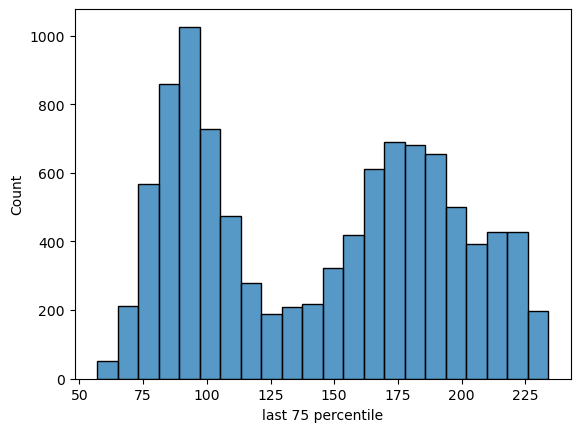

In [29]:
sns.histplot(ds_ripeness['last 75 percentile'])

<Axes: xlabel='last 75 percentile', ylabel='observed time to yellow ripeness'>

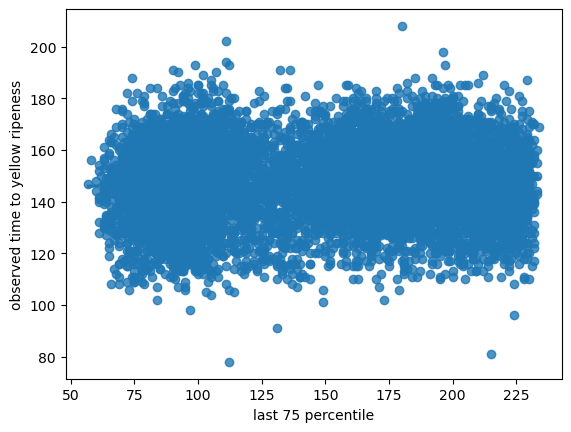

In [28]:
sns.regplot(x='last 75 percentile', y='observed time to yellow ripeness', data=ds_ripeness)

In [29]:
def train_and_run_tree(ds, 
                       phase_list = ['yellow ripeness'],
                       training_columns =  [f't2m at day {n}' for n in range(200)],
                       response_columns =['observed time to yellow ripeness']):
    train, test = train_test_split(ds, test_size=0.2, random_state = 1)
    #clf = GradientBoostingRegressor(
    #    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,
    #    loss='squared_error'
    #)
    clf = RandomForestRegressor()#max_depth=3, random_state=0, min_samples_leaf=1)
    X_training = train[training_columns].values
    y_training = train[response_columns].values.ravel()
    X_eval = test[training_columns].values
    y_eval = test[response_columns].values.ravel()
    clf_fit = clf.fit(X_training, y_training)
    for phase_index, phase in enumerate(phase_list):
        train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:, 
        test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:, 
        train[f'ML check obs to {phase}'] = y_training#[phase_index]#:, 
        test[f'ML check obs to {phase}'] = y_eval#[phase_index]#:, 
    test['train_test'] = 'test'
    train['train_test'] = 'train'
    ds_results = pd.concat([test, train], axis=0)
    return test, train

In [18]:
def plot_modelled_observed(ds, phase_list = ['yellow ripeness'], font_size = 20):
    for phase in phase_list:
        fig, axs = plt.subplots(1, len(phase_list), figsize = (len(phase_list)*5, 5))
        minval = min(ds[f'observed time to {phase}'].min(), ds[f'RF to {phase}'].min()) - 1
        maxval = max(ds[f'observed time to {phase}'].max(), ds[f'RF to {phase}'].max()) + 1
        sns.regplot(x=f'RF to {phase}', y=f'observed time to {phase}', data=ds, ax=axs,
                    scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 5))
        axs.plot([minval, maxval], [minval, maxval], linestyle='--', color='k', lw=1, scalex=False, scaley=False)
        axs.set_xlim(minval, maxval)
        axs.set_ylim(minval, maxval)
        axs.set_title(f'Comparison of modelled and observed time to {phase}')
        rsquared = r2_score(ds[f'observed time to {phase}'], ds[f'RF to {phase}'])
        print(f'R^2 value for model: {rsquared}')
        bias = ds[f'observed time to {phase}'].mean() - ds[f'RF to {phase}'].mean()
        variance_modelled = ds[f'RF to {phase}'].var()
        print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

In [31]:
test_ripeness_reduced, train_ripeness_reduced = train_and_run_tree(ds_ripeness_reduced,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + ['mingrad', 'maxgrad', 'minday','maxday', 'second last 75 percentile', 'last 75 percentile'], #'mingrad', 'maxgrad', 'minday', 
                                                     response_columns =['observed time to yellow ripeness'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.2533865461480902
Bias: 0.0005885897920601764
Variance of modelled values: 68.7672139679236


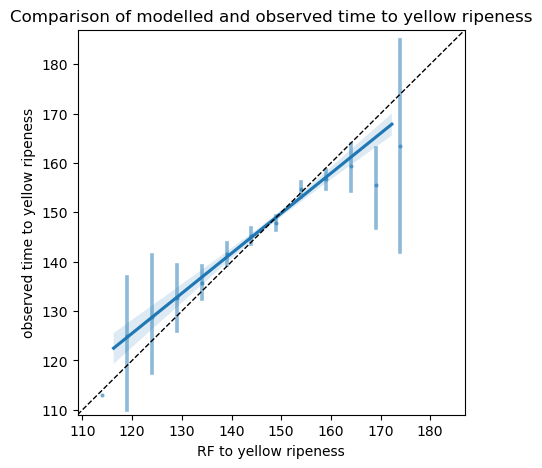

In [32]:
plot_modelled_observed(test_ripeness_reduced, phase_list = ['yellow ripeness'])

In [36]:
test_flowering_reduced, train_flowering_reduced = train_and_run_tree(ds_flowering_reduced,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  ['mingrad', 'maxgrad', 'minday','maxday', 'second last 75 percentile', 'last 75 percentile'], #[f't2m at day {n}' for n in range(200)] + 'mingrad', 'maxgrad', 'minday', 
                                                     response_columns =['observed time to beginning of flowering'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_17708\3910095012.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: -0.028336659912550077
Bias: 0.010633644730622213
Variance of modelled values: 11.766495007687931


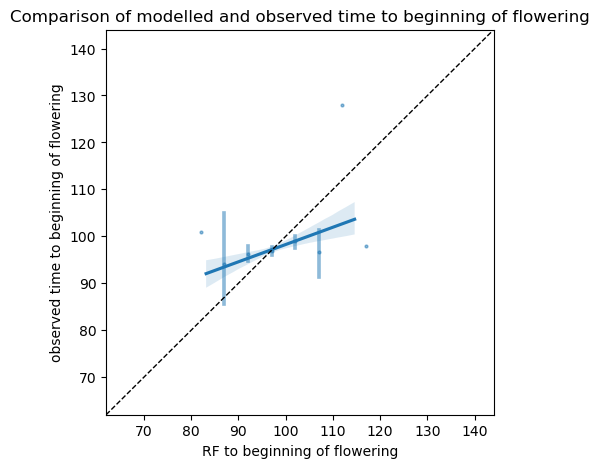

In [37]:
plot_modelled_observed(test_flowering_reduced, phase_list = ['beginning of flowering'])

In [21]:
test_flowering_no_RS, train_flowering_no_RS = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to beginning of flowering'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.32811404125241583
Bias: 0.0010254803033846636
Variance of modelled values: 51.6980812767027


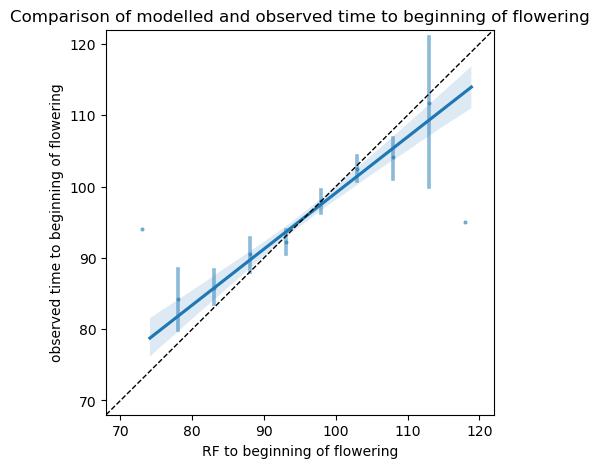

In [23]:
plot_modelled_observed(test_flowering_no_RS, phase_list = ['beginning of flowering'])

In [19]:
test_flowering, train_flowering = train_and_run_tree(ds_flowering,
                                                     phase_list = ['beginning of flowering'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile'],
                                                     response_columns =['observed time to beginning of flowering'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\3910095012.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.4274878662082797
Bias: 0.2370226410838794
Variance of modelled values: 49.80119564128337


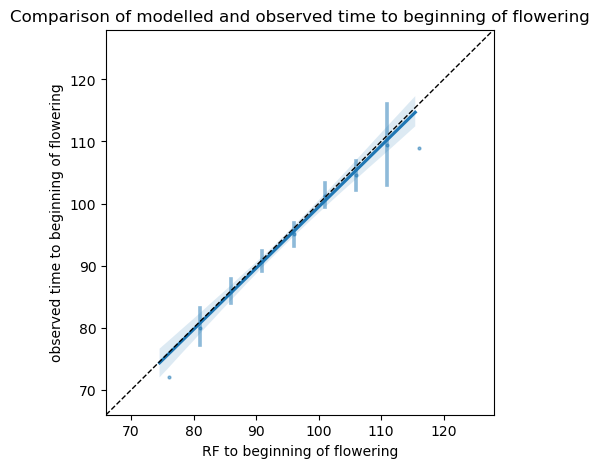

In [20]:
plot_modelled_observed(test_flowering, phase_list = ['beginning of flowering'])

In [30]:
test_ripeness_no_RS, train_ripeness_no_RS = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)],
                                                     response_columns =['observed time to yellow ripeness'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.41503697995295885
Bias: 0.10064526360006716
Variance of modelled values: 111.72566371755995


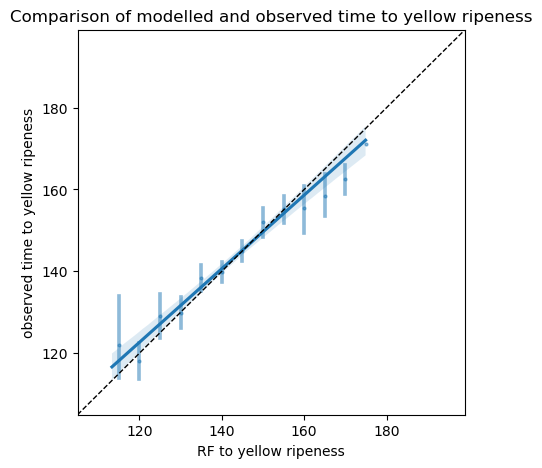

In [31]:
plot_modelled_observed(test_ripeness_no_RS, phase_list = ['yellow ripeness'])

In [32]:
test_ripeness, train_ripeness = train_and_run_tree(ds_ripeness,
                                                     phase_list = ['yellow ripeness'],
                                                     training_columns =  [f't2m at day {n}' for n in range(200)] + ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile'],
                                                     response_columns =['observed time to yellow ripeness'])

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:,
C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_20420\2885207749.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

R^2 value for model: 0.4311816142199918
Bias: 0.15212260953579806
Variance of modelled values: 109.86026697337375


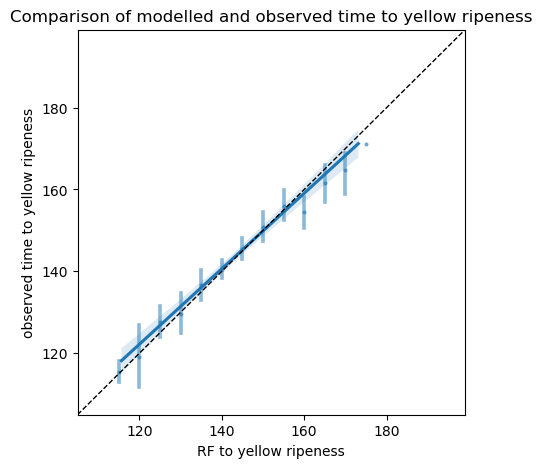

In [33]:
plot_modelled_observed(test_ripeness, phase_list = ['yellow ripeness'])

In [49]:
def permutation_importance_all_vars(ds, training_columns, response_columns, clf_fit):
    X_eval = ds[training_columns].values
    y_eval = ds[response_columns].values

    r = permutation_importance(clf_fit, X_eval, y_eval,
                            n_repeats=30,
                            random_state=0)

    for i in r.importances_mean.argsort()[::-1]:
        #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{training_columns[i]:<15}",
                f"{r.importances_mean[i]:.3f}",
                f" +/- {r.importances_std[i]:.3f}")

In [11]:
#ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
#ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data4.csv')

#day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
#for colname in day_columns:
#    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear

In [13]:
ds['year'].unique()

array([2022., 2023., 2008., 2010., 2011., 2016., 2018., 2019., 2020.,
       2004., 2006., 2007., 2002., 2003., 2012., 2014., 2015.])

In [8]:
station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_24716\1289162695.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  station_data = pd.read_csv("https://opendata.dwd.de/climate_environment/CDC/help/PH_Beschreibung_Phaenologie_Stationen_Jahresmelder.txt",sep = ";\s+|;\t+|;\s+\t+|;\t+\s+|;|\s+;|\t+;|\s+\t+;|\t+\s+;", encoding='cp1252', on_bad_lines='skip')


In [8]:
ds_LSP = ds_LSP.rename(columns = {'Stations_Id': 'Stations_id'})
ds_LSP = get_station_locations(ds_LSP, station_data)
ds = ds_LSP
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear

Text(0.5, 1.0, 'bad')

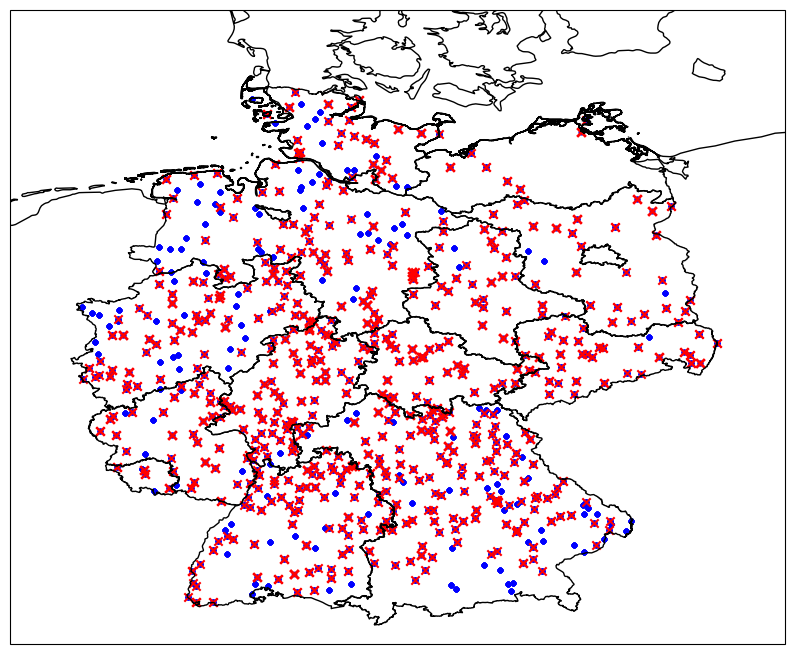

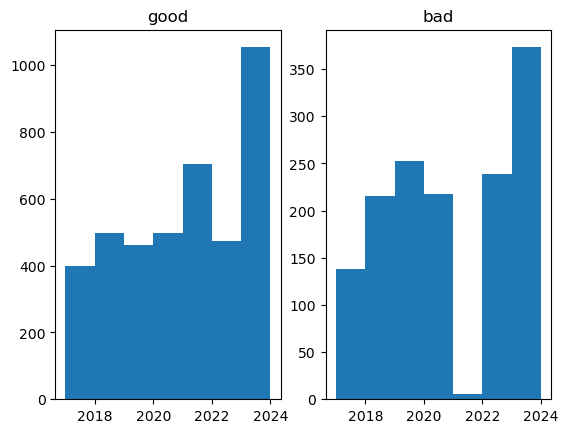

In [25]:
fig, ax = plotting.Germany_plot()
#ds_good_LSP = ds.where(ds['maxday'] > 150)
#ds_good_LSP = ds.where((ds['maxgrad'] < ds['mingrad']))#*(ds['year'] > 2020))
ds_good_LSP = ds.where((ds['second last 75 percentile'] > 150) * (ds['last 75 percentile'] > 150))# * (ds['last 75 percentile'] < 270) * (ds['second last 75 percentile'] < 270))
#ds_bad_LSP = ds.where(ds['maxday'] < 150)
#ds_bad_LSP = ds.where((ds['maxgrad'] > ds['mingrad']))#*(ds['year'] > 2020))
ds_bad_LSP = ds.where(~((ds['second last 75 percentile'] > 150) * (ds['last 75 percentile'] > 150)))# * (ds['last 75 percentile'] < 270) * (ds['second last 75 percentile'] < 270)))
ax.scatter(ds_good_LSP['lon'], ds_good_LSP['lat'], c='blue', label='good', s = 10)
ax.scatter(ds_bad_LSP['lon'], ds_bad_LSP['lat'], c='red', label='bad', marker='x')

fig, ax = plt.subplots(1, 2)
ax[0].hist(ds_good_LSP['year'], bins=7)
ax[0].set_title('good')
ax[1].hist(ds_bad_LSP['year'], bins=7)
ax[1].set_title('bad')


In [22]:
def hist2d_proportions(lats, lons, subset_lats, subset_lons, bin_num=20, font_size = 20, title = 'Frequency of observations of ripeness time by location', colorname = 'Proportion of \'good\' observations', vmax = 0.6, save=False):
    hist_full, lonedges, latedges = np.histogram2d(lons, lats, bins=bin_num)#, range=[[0, 4], [0, 4]])
    hist_subset, lonedges, latedges = np.histogram2d(subset_lons, subset_lats, bins=bin_num)
    hist = (hist_subset/hist_full)*(hist_full>10)
    lonpos, latpos = np.meshgrid(lonedges, latedges, indexing="ij")#np.meshgrid(lonedges[:-1] + sizelon, latedges[:-1] + sizelat, indexing="ij")
    lonpos = lonpos#.ravel()
    latpos = latpos#.ravel()
    fig, ax = plotting.Germany_plot(figsize = (10, 10))
    ax.set_title(title, fontsize = font_size)
    densities = ax.pcolormesh(lonpos, latpos, hist, cmap='Purples', vmax = vmax, vmin = 0)
    cbar = plt.colorbar(densities, fraction = 0.03)
    cbar.set_label(label = colorname, size=font_size)
    cbar.ax.tick_params(labelsize=font_size - 2)
    if save:
        fig.savefig(f'plots/bad_obs.png', bbox_inches='tight')

In [27]:
print(len(all_latlon), len(good_latlon))

5531 4090


C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_40376\460333463.py:4: RuntimeWarning: invalid value encountered in divide
  hist = (hist_subset/hist_full)*(hist_full>10)


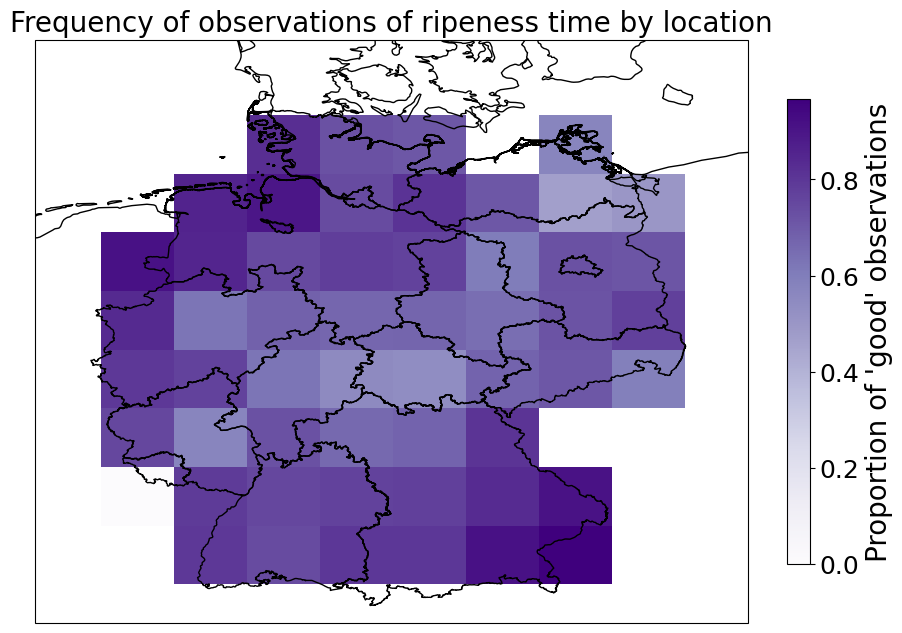

In [28]:
good_latlon = ds_good_LSP[['lat', 'lon']].dropna()
bad_latlon = ds_bad_LSP[['lat', 'lon']].dropna()
all_latlon = ds[['lat', 'lon']].dropna()
hist2d_proportions(all_latlon['lat'], all_latlon['lon'], good_latlon['lat'], good_latlon['lon'], bin_num = 8, vmax=None)#, vmax = 0.6)

C:\Users\wlwc1989\AppData\Local\Temp\ipykernel_40376\460333463.py:4: RuntimeWarning: invalid value encountered in divide
  hist = (hist_subset/hist_full)*(hist_full>10)


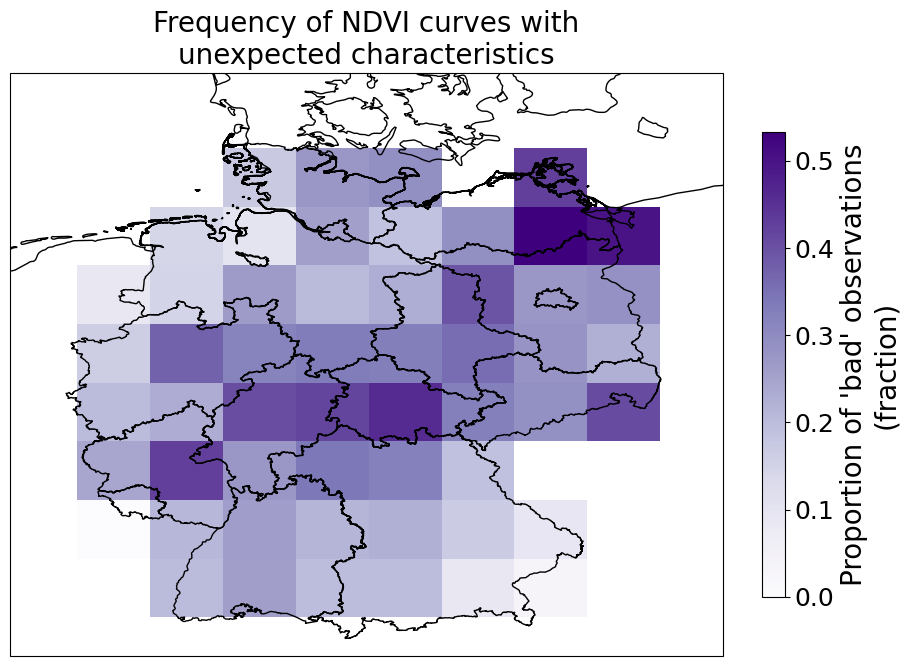

In [31]:
hist2d_proportions(all_latlon['lat'], all_latlon['lon'], bad_latlon['lat'], bad_latlon['lon'], bin_num = 8, vmax = None,
                   title='Frequency of NDVI curves with\nunexpected characteristics',
                   colorname = 'Proportion of \'bad\' observations\n(fraction)', save=True)

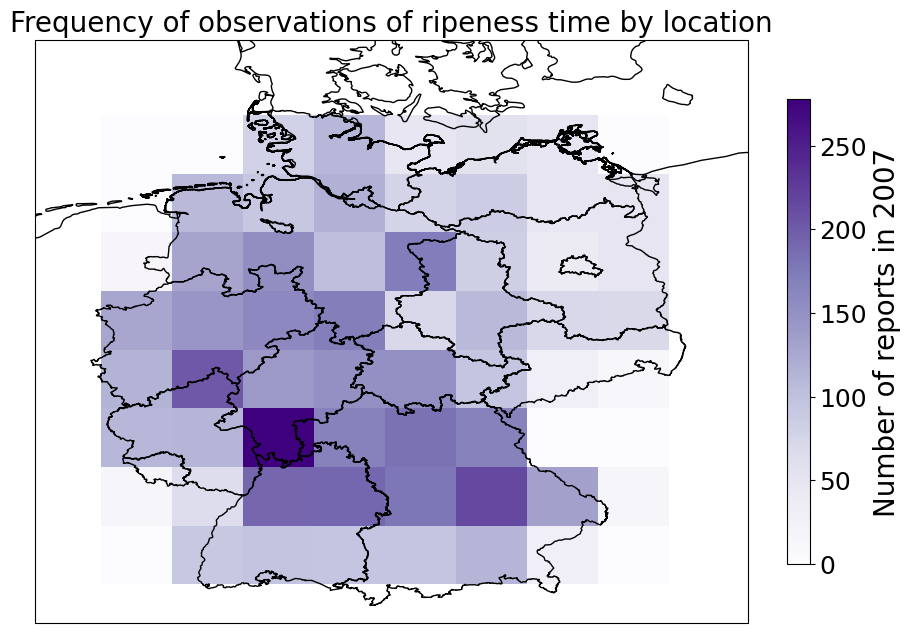

In [42]:
plotting.hist2d_locations(all_latlon['lat'], all_latlon['lon'], bin_num=8)

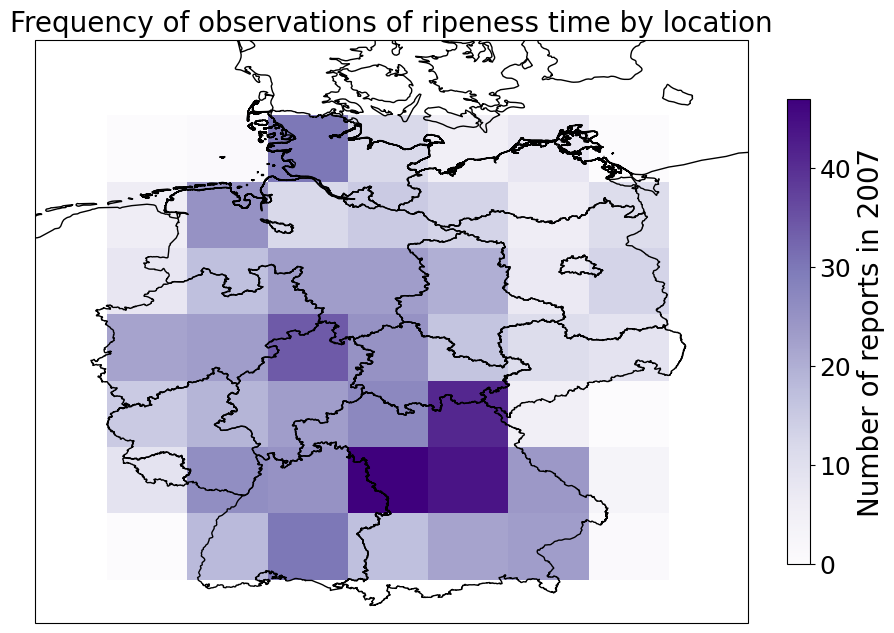

In [17]:
good_latlon = ds_good_LSP[['lat', 'lon']].dropna()
plotting.hist2d_locations(good_latlon['lat'], good_latlon['lon'], bin_num = 7)

In [19]:
len(good_latlon)

814

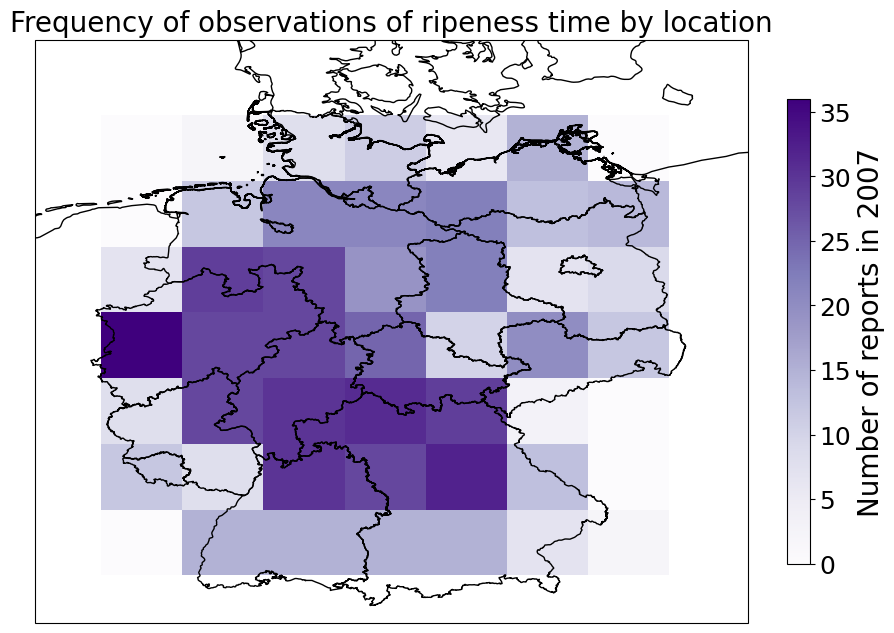

In [20]:
bad_latlon = ds_bad_LSP[['lat', 'lon']].dropna()
plotting.hist2d_locations(bad_latlon['lat'], bad_latlon['lon'], bin_num = 7)

In [82]:
len(ds.where(ds['modelled time to emergence'] < 400)['modelled time to emergence'].dropna())

1112

In [81]:
len(ds)

1673

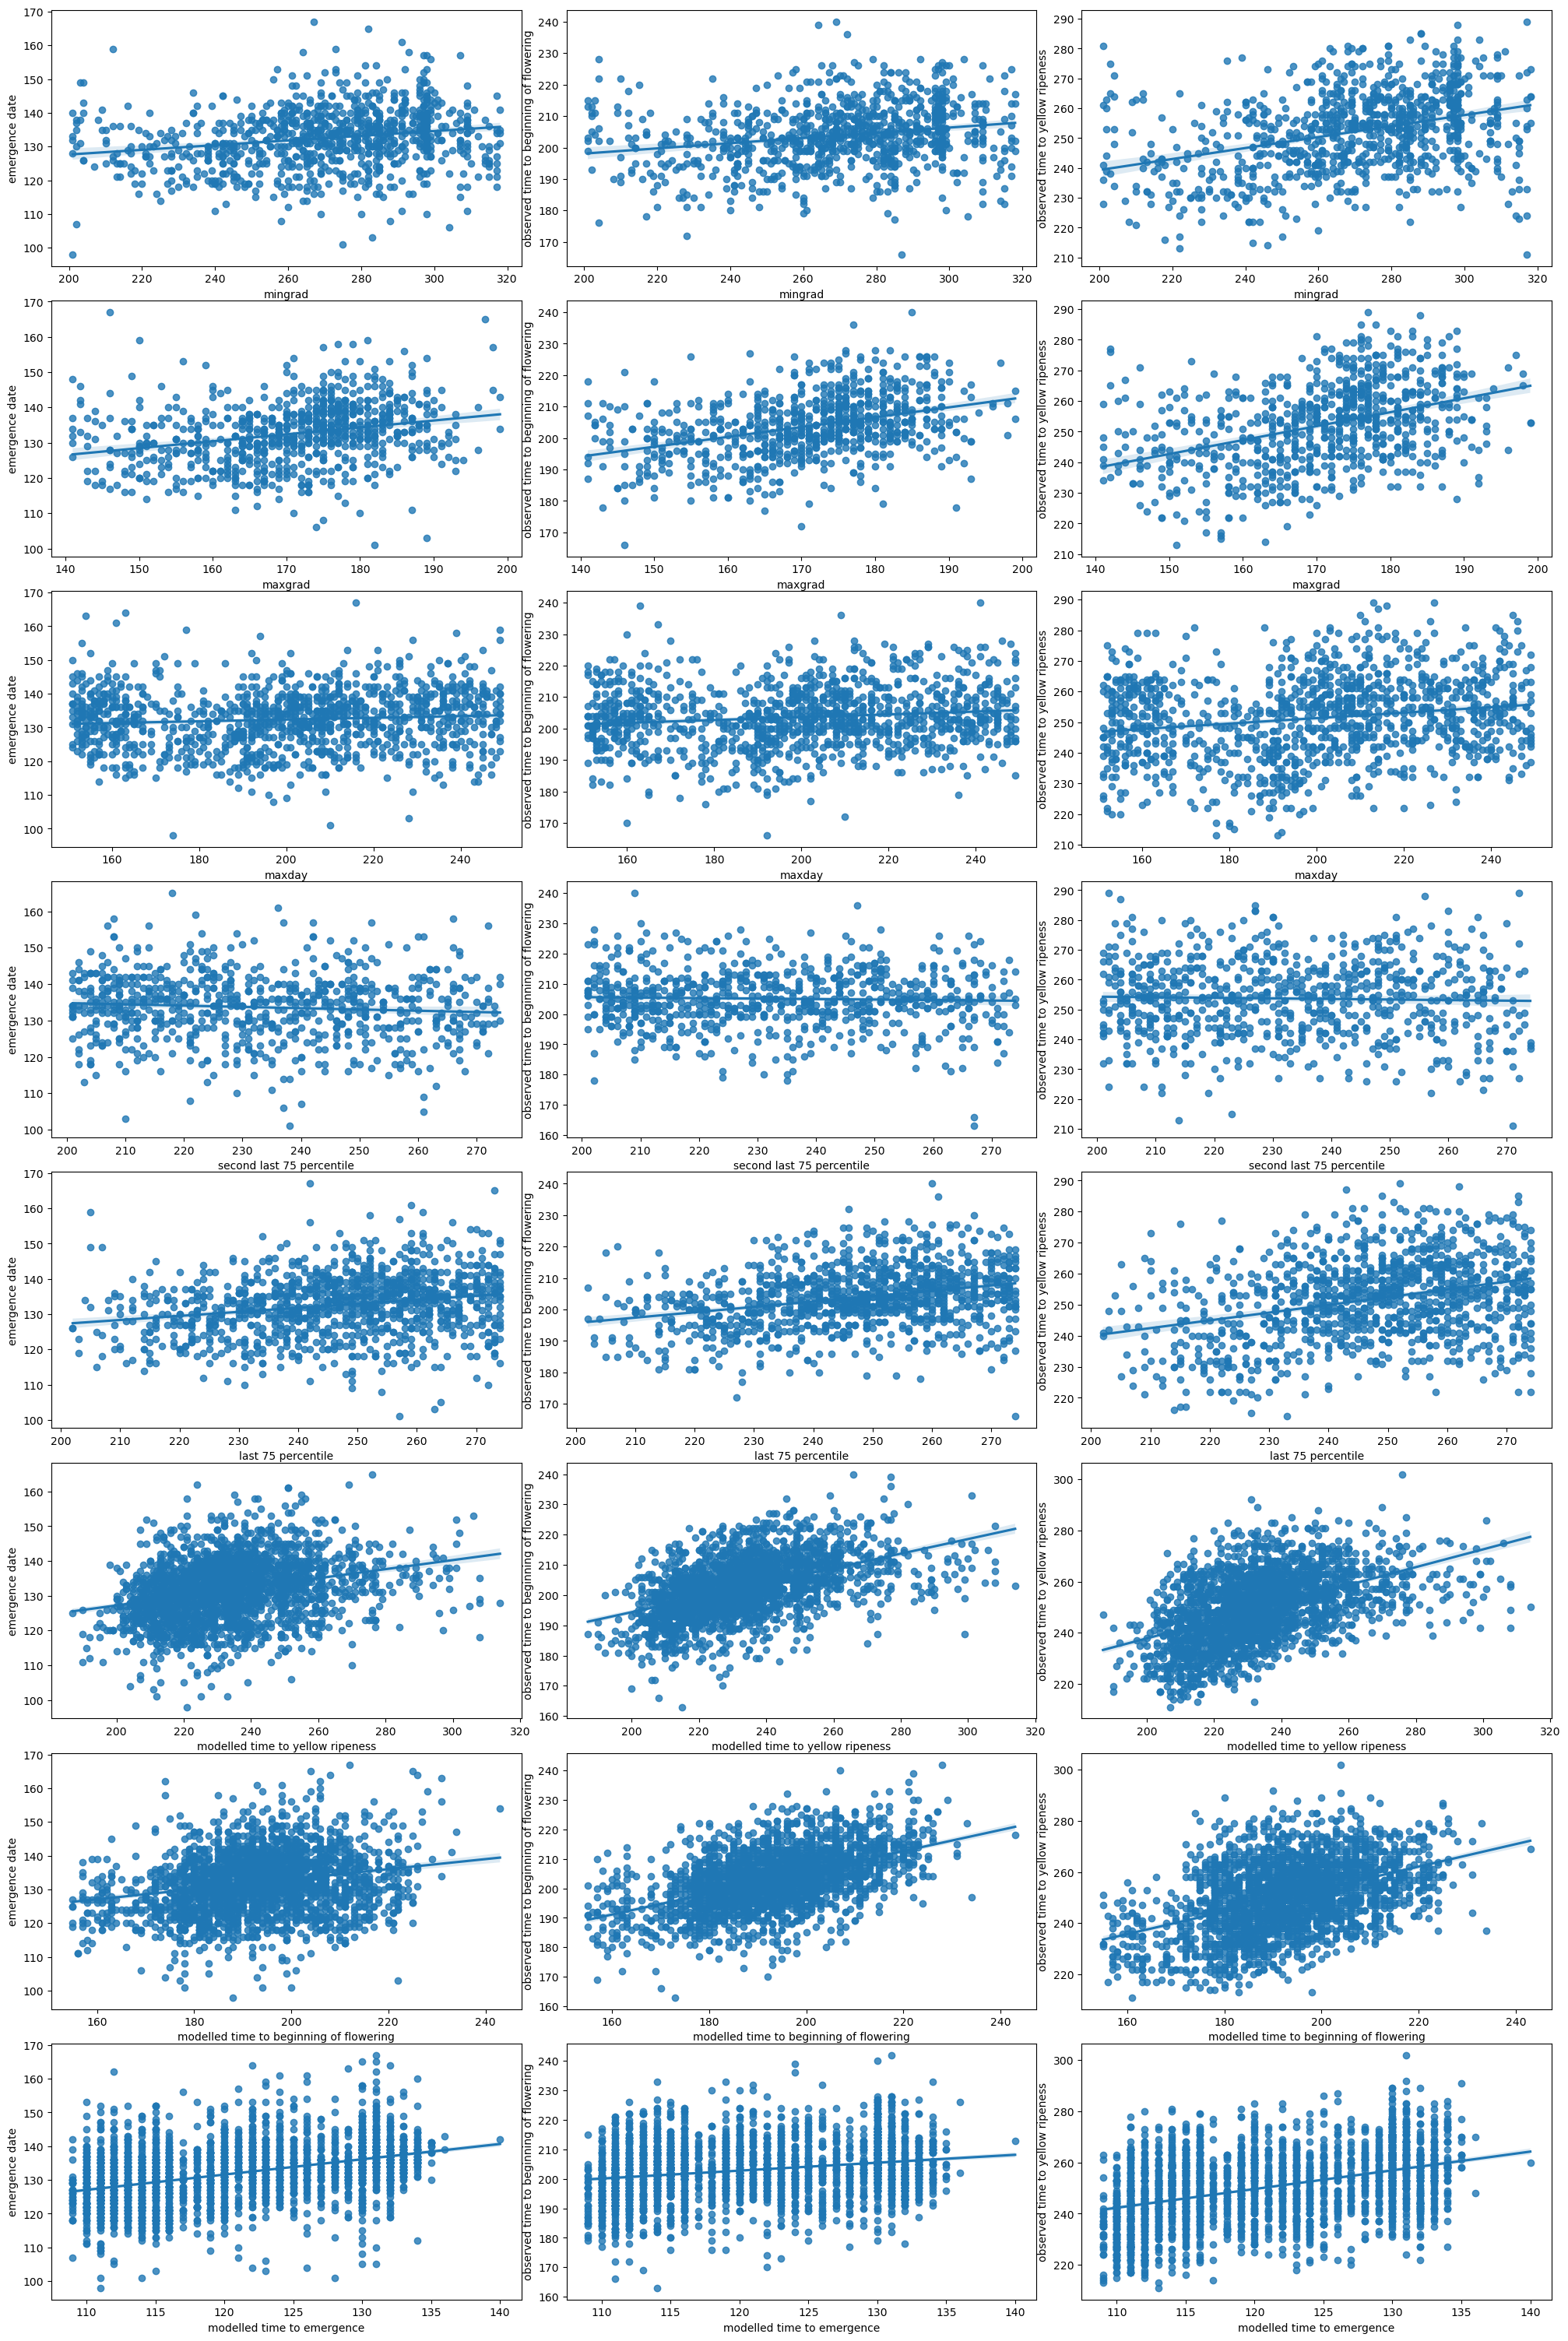

In [9]:
fig, axes = plt.subplots(8, 3, figsize = (20, 30))
fig.tight_layout()
predictors = ['mingrad', 'maxgrad', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'modelled time to yellow ripeness', 'modelled time to beginning of flowering', 'modelled time to emergence']
observed_variables = ['emergence date', 'observed time to beginning of flowering', 'observed time to yellow ripeness']

ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to beginning of flowering', 'emergence date'])
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 'tas', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear
ds['observed time to beginning of flowering'] = ds['observed time to beginning of flowering'] + ds['emergence date']
ds['observed time to yellow ripeness'] = ds['observed time to yellow ripeness'] + ds['emergence date']
ds['modelled time to emergence'] = ds['modelled time to emergence'] + pd.to_datetime(ds['WC SOS']).dt.dayofyear
ds['modelled time to beginning of flowering'] = ds['modelled time to beginning of flowering'] + ds['modelled time to emergence']
ds['modelled time to yellow ripeness'] = ds['modelled time to yellow ripeness'] + ds['modelled time to emergence']
for observed_variable in observed_variables:
    ds = ds.where((ds[observed_variable] < 365)*(ds[observed_variable] > 0))
for predictor_index, predictor in enumerate(predictors):
    for observed_variable_index, observed_variable in enumerate(observed_variables):
        if predictor == 'mingrad' or predictor == 'maxgrad':
            ds_no_outliers = ds.where(ds['mingrad'] > ds['maxgrad']).dropna(how='all')
            if predictor == 'mingrad':
                ds_no_outliers = ds_no_outliers.where((ds_no_outliers[predictor] > 200)).dropna(how='all')
            elif predictor == 'maxgrad':
                ds_no_outliers = ds_no_outliers.where((ds_no_outliers[predictor] < 200)*(ds_no_outliers[predictor] > 140)).dropna(how='all')
        elif predictor == 'maxday':
            ds_no_outliers = ds.where((ds[predictor] < 250)*(ds[predictor] > 150)).dropna(how='all')
        elif predictor == 'second last 75 percentile' or predictor == 'last 75 percentile':
            ds_no_outliers = ds.where((ds[predictor] < 275)*(ds[predictor] > 200)).dropna(how='all')
        elif predictor == 'modelled time to emergence' or predictor == 'modelled time to beginning of flowering' or predictor == 'modelled time to yellow ripeness':
            ds_no_outliers = ds.where(ds[predictor] < 365).dropna(how='all')
            #if predictor == 'modelled time to beginning of flowering' or predictor == 'modelled time to yellow ripeness':
            #    ds_no_outliers = ds_no_outliers.where(ds_no_outliers[predictor] > ds_no_outliers['modelled time to emergence'] + 5).dropna(how='all')
        else:
            ds_no_outliers = ds
        

        sns.regplot(x=predictor, y=observed_variable, data=ds_no_outliers, ax=axes[predictor_index, observed_variable_index])

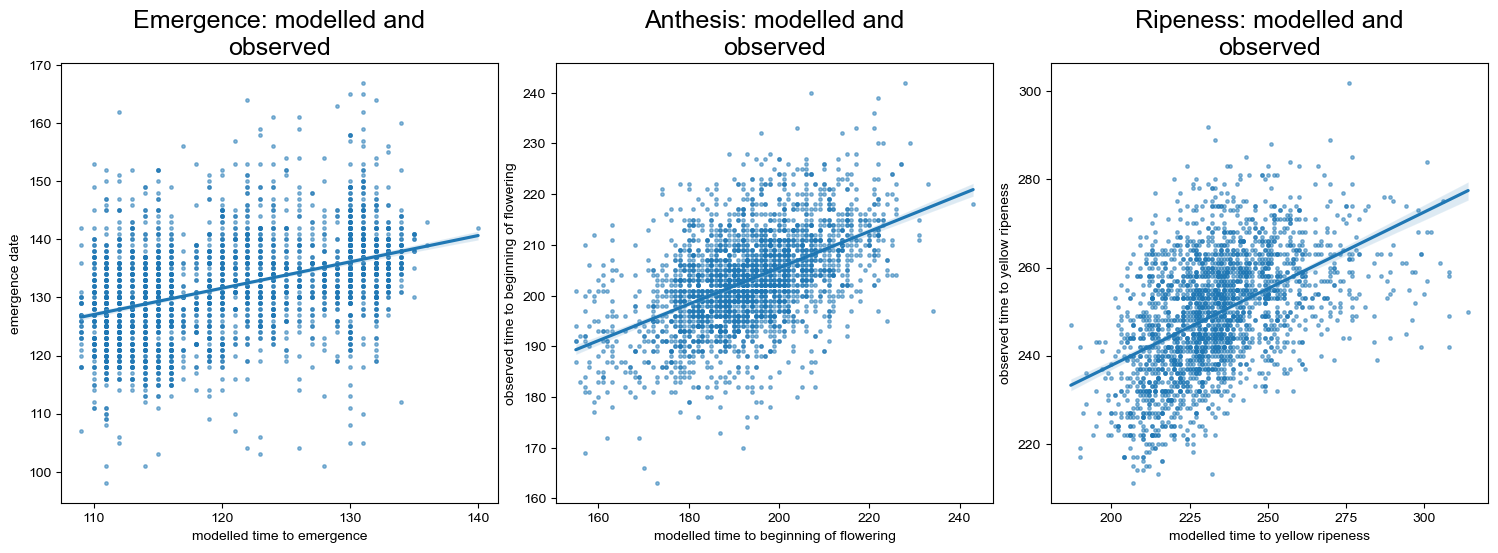

In [10]:
fig, axes = plt.subplots(1, 3, figsize = (15, 5))
fig.tight_layout()
predictors = ['modelled time to emergence', 'modelled time to beginning of flowering', 'modelled time to yellow ripeness']
observed_variables = ['emergence date', 'observed time to beginning of flowering', 'observed time to yellow ripeness']

ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to beginning of flowering', 'emergence date'])
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 'tas', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear
ds['observed time to beginning of flowering'] = ds['observed time to beginning of flowering'] + ds['emergence date']
ds['observed time to yellow ripeness'] = ds['observed time to yellow ripeness'] + ds['emergence date']
ds['modelled time to emergence'] = ds['modelled time to emergence'] + pd.to_datetime(ds['WC SOS']).dt.dayofyear
ds['modelled time to beginning of flowering'] = ds['modelled time to beginning of flowering'] + ds['modelled time to emergence']
ds['modelled time to yellow ripeness'] = ds['modelled time to yellow ripeness'] + ds['modelled time to emergence']
for observed_variable in observed_variables:
    ds = ds.where((ds[observed_variable] < 365)*(ds[observed_variable] > 0))
for predictor_index, predictor in enumerate(predictors):
    variable_name = ['Emergence', 'Anthesis', 'Ripeness'][predictor_index]
    observed_variable_index = predictor_index
    observed_variable = observed_variables[observed_variable_index]
    ds_no_outliers = ds.where(ds[predictor] < 365).dropna(how='all')
    sns.set(font_scale=1.5)
    sns.regplot(x=predictor, y=observed_variable, data=ds_no_outliers, ax=axes[predictor_index],
                scatter_kws={'alpha':0.5, 's':6})
    axes[predictor_index].set_title(f'{variable_name}: modelled and\nobserved')
fig.savefig('plots/modelled_vs_observed.png', bbox_inches='tight')

In [39]:
ds_t2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data4.csv')
ds_d2m = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_d2m.csv')
ds_d2m = ds_d2m.drop(['Unnamed: 0', 'lat', 'lon', 'WC SOS', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'emergence date'], axis = 1)
ds_ssrd = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_ssrd.csv')
ds_ssrd = ds_ssrd.drop(['Unnamed: 0', 'lat', 'lon', 'WC SOS', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'emergence date'], axis = 1)
ds_tp = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data_tp.csv')
ds_tp = ds_tp.drop(['Unnamed: 0', 'lat', 'lon', 'WC SOS', 'observed time to beginning of flowering', 'observed time to yellow ripeness', 'emergence date'], axis = 1)
ds_reanalysis1 = pd.merge(ds_t2m, ds_d2m, on = ['Stations_id', 'Referenzjahr'], how = 'inner')
ds_reanalysis2 = pd.merge(ds_ssrd, ds_tp, on = ['Stations_id', 'Referenzjahr'], how = 'inner')
ds_reanalysis = pd.merge(ds_reanalysis1, ds_reanalysis2, on = ['Stations_id', 'Referenzjahr'], how = 'inner')
print('Should be all the same if it worked: ', len(ds_reanalysis), len(ds_ssrd), len(ds_tp), len(ds_d2m))

Should be all the same if it worked:  4914 4914 4914 4914


In [65]:
ds_LSP = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\LSP_times2.csv')
#ds_reanalysis = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\Maize_ML_data3.csv')
ds_reanalysis = ds_reanalysis.rename(columns={'Stations_id': 'Stations_Id', 'Referenzjahr': 'year'})
ds = pd.merge(ds_LSP, ds_reanalysis, on=['Stations_Id', 'year'], how='outer')
ds = ds.dropna(subset=['observed time to yellow ripeness', 'emergence date', 't2m day 0'])
ds = ds.where(ds['observed time to yellow ripeness'] > 0).dropna(how='all')
ds = ds.reset_index().drop(['index', 'Unnamed: 0_x', 'Unnamed: 0_y'], axis=1)
ds = make_cumulative(ds, driver_variable = 't2m', numdays = 200)
ds = make_cumulative(ds, driver_variable = 'tp', numdays = 200)
ds = make_cumulative(ds, driver_variable = 'ssrd', numdays = 200)
ds = make_cumulative(ds, driver_variable = 'd2m', numdays = 200)
day_columns = ['mingrad', 'maxgrad', 'minday', 'maxday', 'second last 75 percentile', 'last 75 percentile', 'emergence date']
for colname in day_columns:
    ds[colname] = pd.to_datetime(ds[colname]).dt.dayofyear
#ds = ds.where((ds['last 75 percentile'] < 275)*(ds['last 75 percentile'] > 200)).dropna(how='all')
#ds = ds.where(ds['maxgrad'] < ds['mingrad']).dropna(how='all')
thinning_num = 40

In [49]:
ds

level_0    year  Stations_Id  mingrad  maxgrad  minday  maxday  \
0           0  2018.0       7521.0    103.0    163.0   130.0   191.0   
1           1  2019.0       7521.0    189.0    313.0   217.0   141.0   
2           2  2020.0       7521.0    172.0    228.0   207.0   121.0   
3           3  2021.0       7521.0    297.0    179.0   155.0   231.0   
4           4  2022.0       7521.0    228.0    188.0   106.0   281.0   
...       ...     ...          ...      ...      ...     ...     ...   
2123     6315  2023.0      19700.0      NaN      NaN     NaN     NaN   
2124     6327  2023.0      19722.0      NaN      NaN     NaN     NaN   
2125     6328  2018.0      19724.0      NaN      NaN     NaN     NaN   
2126     6334  2018.0      19727.0      NaN      NaN     NaN     NaN   
2127     6335  2019.0      19727.0      NaN      NaN     NaN     NaN   

      second last 75 percentile  last 75 percentile  t2m day 0  ...  \
0                         235.0               236.0   8.120025  ...   
1                         104.0               159.0   5.582989  ...   
2                         105.0               150.0   5.267146  ...   
3                         263.0               265.0   4.266895  ...   
4                         222.0               261.0   7.686438  ...   
...                         ...                 ...        ...  ...   
2123                        NaN                 NaN   5.713335  ...   
2124                        NaN                 NaN   4.639520  ...   
2125                        NaN                 NaN  12.007923  ...   
2126                        NaN                 NaN  11.099592  ...   
2127                        NaN                 NaN   6.435608  ...   

      tp day 190  tp day 191  tp day 192  tp day 193  tp day 194  tp day 195  \
0       1.079194    1.097430    1.100882    1.102217    1.125145    1.132307   
1       2.149894    2.150392    2.150671    2.155572    2.157814    2.163171   
2       1.729573    1.736761    1.737511    1.742701    1.762747    1.772651   
3       2.423310    2.430643    2.430654    2.431859    2.444890    2.449248   
4       1.505837    1.508876    1.522803    1.528690    1.529857    1.529936   
...          ...         ...         ...         ...         ...         ...   
2123    1.774917    1.789063    1.813220    1.833408    1.838644    1.842771   
2124    2.452768    2.460860    2.461400    2.469852    2.493725    2.497888   
2125    0.670239    0.675225    0.680017    0.683380    0.684747    0.685769   
2126    1.346113    1.348694    1.381384    1.395194    1.401051    1.404730   
2127    2.151982    2.151998    2.152081    2.152841    2.152966    2.171707   

      tp day 196  tp day 197  tp day 198  tp day 199  
0       1.133410    1.144167    1.154736    1.162982  
1       2.168591    2.169808    2.169819    2.169821  
2       1.773627    1.793633    1.818072    1.861151  
3       2.449459    2.449459    2.451668    2.460435  
4       1.530059    1.530777    1.535976    1.536664  
...          ...         ...         ...         ...  
2123    1.873079    1.880978    1.884756    1.886885  
2124    2.529235    2.542170    2.550203    2.573253  
2125    0.685935    0.686724    0.688105    0.688996  
2126    1.406385    1.412935    1.441650    1.450446  
2127    2.175680    2.175960    2.176076    2.176090  

[2128 rows x 818 columns]

In [74]:
training_columns =  [f'd2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + [f'ssrd day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] #+[f't2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] +  [f'tp day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + [f'd2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] #['modelled time to emergence', 'modelled time to beginning of flowering', 'modelled time to yellow ripeness'] +[f't2m day {thinning_num*n}' for n in range(np.int64(200/thinning_num))] + ['mingrad', 'maxgrad', 'minday', 'maxday',  'second last 75 percentile', 'last 75 percentile'] #['mingrad', 'maxgrad', 'minday', 'maxday',  'second last 75 percentile', 'last 75 percentile']##+ ['mingrad', 'maxgrad', 'last 75 percentile'] ['mingrad', 'maxgrad', 'last 75 percentile'] #+   ##
response_columns =['observed time to yellow ripeness']# ['observed time emergence to beginning of flowering', 'emergence date']#['observed time emergence to beginning of flowering', 'observed time emergence to yellow ripeness', 'emergence date']#['observed time emergence to yellow ripeness']#
ds2 = ds.dropna(subset = training_columns + response_columns).reset_index()
training, verification = subsample(ds2, subsample_frac = 0.9)

In [75]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth = 3,
                             min_samples_leaf=2)
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingRegressor(
    n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0,
    loss='squared_error'
)
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor()#max_depth=3, random_state=0, min_samples_leaf=1)
X_training = training[training_columns].values
y_training = training[response_columns].values.ravel()
X_eval = verification[training_columns].values
y_eval = verification[response_columns].values.ravel()
clf_fit = clf.fit(X_training, y_training)
phase_list = ['yellow ripeness']#['beginning of flowering', 'emergence']#['beginning of flowering', 'yellow ripeness', 'emergence']
for phase_index, phase in enumerate(phase_list):
    training.loc[:, f'RF to {phase}'] = clf_fit.predict(X_training)#[phase_index]#:, 
    verification.loc[:, f'RF to {phase}'] = clf_fit.predict(X_eval)#[phase_index]#:, 
    training[f'ML check obs to {phase}'] = y_training#[phase_index]#:, 
    verification[f'ML check obs to {phase}'] = y_eval#[phase_index]#:, 
verification['verification'] = 'verification'
training['verification'] = 'training'
ds_results = pd.concat([verification, training], axis=0)
ds_results['modelled time to emergence'] = ds_results['modelled time to emergence'] + pd.to_datetime(ds_results['WC SOS']).dt.dayofyear
ds_results['modelled time to emergence']
ds_results = ds_results.rename(columns = {'observed time emergence to beginning of flowering': 'observed time to beginning of flowering', 
                                          'observed time emergence to yellow ripeness': 'observed time to yellow ripeness'})
ds_results['observed time to emergence'] = ds_results['emergence date']
r2_modelled_observed(ds_results.where(ds_results['verification'] == 'verification').dropna(how = 'all').dropna(subset=['modelled time to emergence']), ['yellow ripeness']) #['emergence', 'beginning of flowering'])#, 'yellow ripeness'


In [77]:
X_eval = verification[training_columns].values
y_eval = verification[response_columns].values

r = permutation_importance(clf_fit, X_eval, y_eval,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    #if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{training_columns[i]:<15}",
            f"{r.importances_mean[i]:.3f}",
            f" +/- {r.importances_std[i]:.3f}")

d2m day 40      0.308  +/- 0.058
ssrd day 40     0.012  +/- 0.022
d2m day 120     0.002  +/- 0.018
ssrd day 160    0.000  +/- 0.014
ssrd day 80     -0.003  +/- 0.013
d2m day 80      -0.008  +/- 0.010
d2m day 160     -0.012  +/- 0.016
ssrd day 120    -0.017  +/- 0.017
d2m day 0       -0.023  +/- 0.010
ssrd day 0      -0.034  +/- 0.016


In [ ]:
import requests
full_catalog_url = 'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/EotG_images/catalog.json'
full_catalog_info = requests.get(full_catalog_url)
first = True
for location_info in full_catalog_info.json()['links'][2:3]:
    labels = []
    if location_info['rel'] == 'child':
        location_url = 'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/EotG_images' + location_info['href'][1:]
        catalog_info = requests.get(location_url)
        print(catalog_info.json()['id'])
        image_links = catalog_info.json()['links']
        locs = catalog_info.json()['extent']['spatial']['bbox'][0]
        for index, infos in enumerate(image_links):
            #print(index)
            image_info_location = infos['href']
            image_info = requests.get(image_info_location)
            if 'assets' in image_info.json().keys():
                image_label_location = image_info.json()['assets']['label']['href']
                image_label = requests.get(image_label_location).json()
                labels.append(image_label[0])
        dataframe_to_add = pd.DataFrame(labels)
        dataframe_to_add['west'] = locs[0]
        dataframe_to_add['south'] = locs[1]
        dataframe_to_add['east'] = locs[2]
        dataframe_to_add['north'] = locs[3]
        if first:
            phen_data = dataframe_to_add
            first = False
        else:
            phen_data = pd.concat([phen_data, dataframe_to_add])
for index, record in phen_data.iterrows():
    if record['growth_stage'] == 'V':
        filename = record['filename']
        print(filename)
        print(f'https://raw.githubusercontent.com/khufkens/EotG_data/main/release_v1/images/{filename}')
print(phen_data['growth_stage'].unique())